# 10章 チューニング技法

In [104]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [105]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [106]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [107]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [108]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [109]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))

# 結果確認
print(n_output)

10


## 10.4 過学習とその対応

### ドロップアウト関数の動作確認

In [110]:
# ドロップアウトテスト用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [111]:
# dropout関数の定義
dropout = nn.Dropout(0.5)

# 訓練フェーズでの挙動
# 訓練フェーズでは、ドロップアウトは有効にする, 学習に参加するユニットは50%の確率で変化する
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測フェーズでの挙動
# 予測フェーズでは、ドロップアウトは無効にする
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


## 10.5 共通関数のライブラリ化

In [112]:
# 共通関数のダウンロード
!git clone https://github.com/silbull/pythonlibs

# 共通関数のロード
from pythonlibs.torch_lib1 import *
from pythonlibs.torch_lib1 import README
# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## データ準備

In [113]:
# Transformsの定義

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [114]:
# データ取得用関数 Dataset

data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [115]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, 
    batch_size = batch_size, shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,  
    batch_size = batch_size, shuffle = False) 

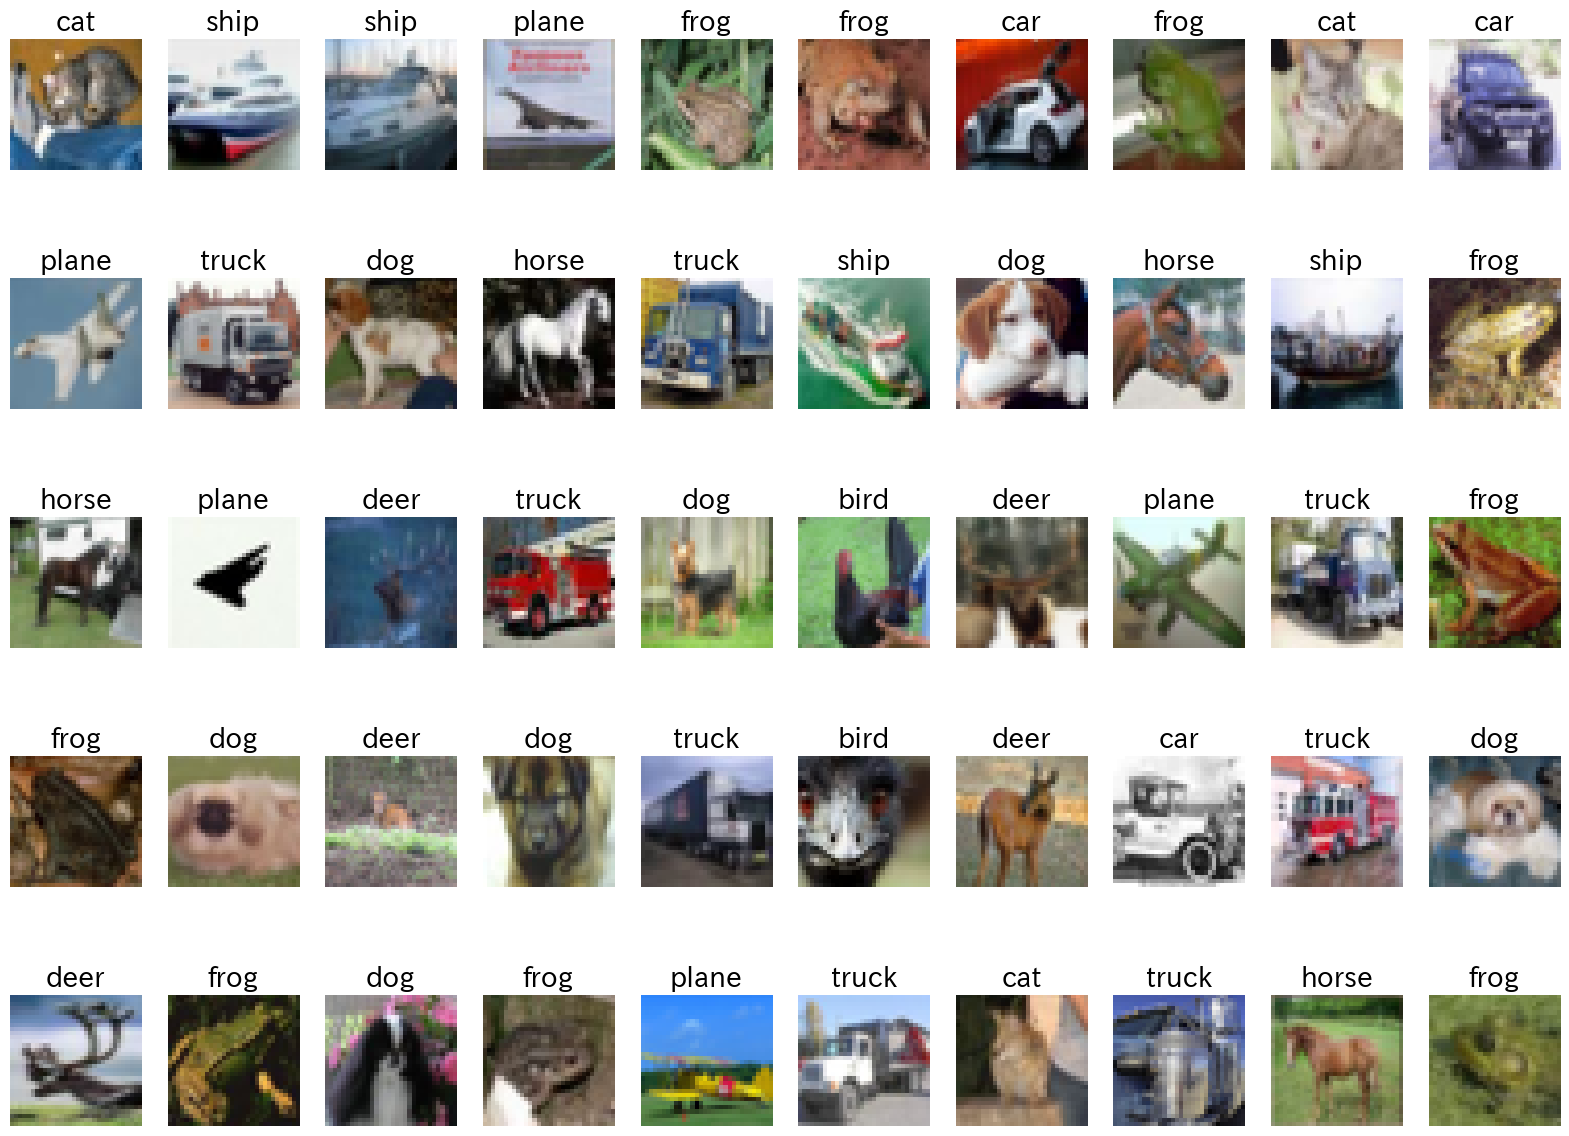

In [116]:
# 最初の50個の表示
show_images_labels(test_loader, classes, None, None)

## 10.6 階層を深くしたモデルの実装

In [117]:
#q: padding(1, 1)とは何か
#a: 画像の周囲に1ピクセル分の余白を追加すること
#q: なぜ余白を追加するのか
#a: 画像の周囲に余白を追加することで、画像の端のピクセルが周囲のピクセルと比較される回数を増やすことができるため
#
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1)) #3チャンネル入力、32チャンネル出力、3x3のフィルタ、余白1
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

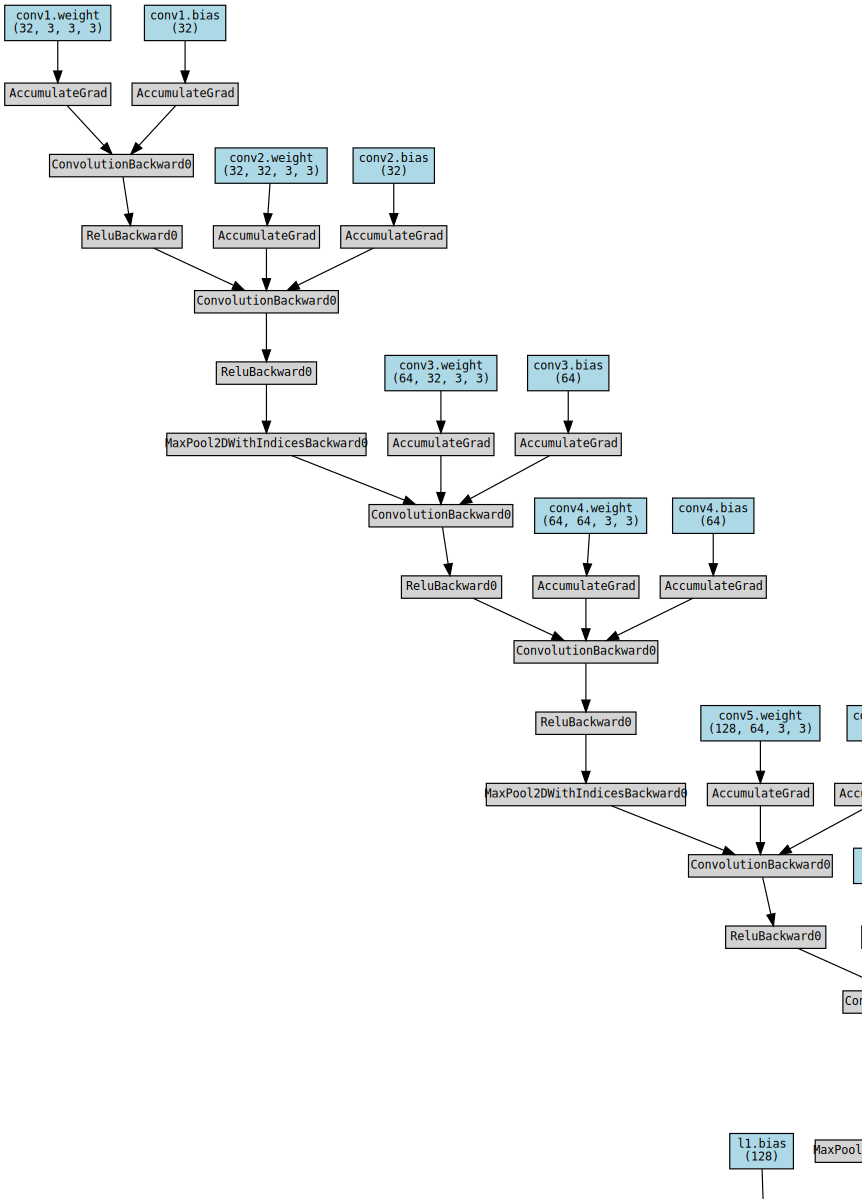

In [118]:
# 損失関数のグラフ表示
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [119]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [120]:
# 多層化したCNNを使って学習
# from pythonlibs.torch_lib1 import fit
num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

100%|██████████| 500/500 [00:12<00:00, 41.04it/s]


Epoch [1/50], loss: 2.30313 acc: 0.10000 val_loss: 2.30278, val_acc: 0.10000


100%|██████████| 500/500 [00:12<00:00, 39.98it/s]


Epoch [2/50], loss: 2.30268 acc: 0.10000 val_loss: 2.30252, val_acc: 0.10000


100%|██████████| 500/500 [00:12<00:00, 39.61it/s]


Epoch [3/50], loss: 2.30248 acc: 0.10000 val_loss: 2.30234, val_acc: 0.10000


100%|██████████| 500/500 [00:12<00:00, 39.86it/s]


Epoch [4/50], loss: 2.30228 acc: 0.10840 val_loss: 2.30210, val_acc: 0.10170


100%|██████████| 500/500 [00:12<00:00, 41.55it/s]


Epoch [5/50], loss: 2.30196 acc: 0.13022 val_loss: 2.30163, val_acc: 0.17490


100%|██████████| 500/500 [00:12<00:00, 40.57it/s]


Epoch [6/50], loss: 2.30118 acc: 0.16744 val_loss: 2.30031, val_acc: 0.19130


100%|██████████| 500/500 [00:12<00:00, 41.22it/s]


Epoch [7/50], loss: 2.29809 acc: 0.18532 val_loss: 2.29353, val_acc: 0.21820


100%|██████████| 500/500 [00:12<00:00, 40.98it/s]


Epoch [8/50], loss: 2.24509 acc: 0.21882 val_loss: 2.09620, val_acc: 0.23870


100%|██████████| 500/500 [00:11<00:00, 41.75it/s]


Epoch [9/50], loss: 2.01599 acc: 0.26136 val_loss: 1.94502, val_acc: 0.29350


100%|██████████| 500/500 [00:12<00:00, 40.70it/s]


Epoch [10/50], loss: 1.90628 acc: 0.31294 val_loss: 1.89259, val_acc: 0.31420


100%|██████████| 500/500 [00:11<00:00, 42.00it/s]


Epoch [11/50], loss: 1.79603 acc: 0.35144 val_loss: 1.69960, val_acc: 0.38820


100%|██████████| 500/500 [00:12<00:00, 40.59it/s]


Epoch [12/50], loss: 1.69664 acc: 0.38332 val_loss: 1.62470, val_acc: 0.41310


100%|██████████| 500/500 [00:12<00:00, 41.54it/s]


Epoch [13/50], loss: 1.62865 acc: 0.40630 val_loss: 1.55995, val_acc: 0.42860


100%|██████████| 500/500 [00:12<00:00, 39.97it/s]


Epoch [14/50], loss: 1.57438 acc: 0.42166 val_loss: 1.61395, val_acc: 0.41620


100%|██████████| 500/500 [00:12<00:00, 38.96it/s]


Epoch [15/50], loss: 1.53052 acc: 0.43842 val_loss: 1.50619, val_acc: 0.44430


100%|██████████| 500/500 [00:12<00:00, 38.78it/s]


Epoch [16/50], loss: 1.48178 acc: 0.45920 val_loss: 1.43978, val_acc: 0.47320


100%|██████████| 500/500 [00:12<00:00, 39.95it/s]


Epoch [17/50], loss: 1.44028 acc: 0.47402 val_loss: 1.40446, val_acc: 0.48450


100%|██████████| 500/500 [00:12<00:00, 39.55it/s]


Epoch [18/50], loss: 1.39892 acc: 0.49384 val_loss: 1.42726, val_acc: 0.48680


100%|██████████| 500/500 [00:12<00:00, 39.08it/s]


Epoch [19/50], loss: 1.35484 acc: 0.51234 val_loss: 1.34538, val_acc: 0.50970


100%|██████████| 500/500 [00:12<00:00, 41.34it/s]


Epoch [20/50], loss: 1.31122 acc: 0.53286 val_loss: 1.29564, val_acc: 0.52930


100%|██████████| 500/500 [00:12<00:00, 41.50it/s]


Epoch [21/50], loss: 1.25929 acc: 0.55008 val_loss: 1.23263, val_acc: 0.55580


100%|██████████| 500/500 [00:13<00:00, 38.25it/s]


Epoch [22/50], loss: 1.21810 acc: 0.56680 val_loss: 1.21244, val_acc: 0.56290


100%|██████████| 500/500 [00:12<00:00, 40.11it/s]


Epoch [23/50], loss: 1.17508 acc: 0.58104 val_loss: 1.19968, val_acc: 0.57280


100%|██████████| 500/500 [00:12<00:00, 38.92it/s]


Epoch [24/50], loss: 1.14220 acc: 0.59540 val_loss: 1.16109, val_acc: 0.58360


100%|██████████| 500/500 [00:12<00:00, 38.93it/s]


Epoch [25/50], loss: 1.09887 acc: 0.61068 val_loss: 1.12124, val_acc: 0.59900


100%|██████████| 500/500 [00:13<00:00, 38.41it/s]


Epoch [26/50], loss: 1.06185 acc: 0.62464 val_loss: 1.10502, val_acc: 0.60950


100%|██████████| 500/500 [00:12<00:00, 40.61it/s]


Epoch [27/50], loss: 1.02270 acc: 0.64096 val_loss: 1.11813, val_acc: 0.60420


100%|██████████| 500/500 [00:12<00:00, 40.42it/s]


Epoch [28/50], loss: 0.98713 acc: 0.65196 val_loss: 1.05660, val_acc: 0.62970


100%|██████████| 500/500 [00:12<00:00, 41.48it/s]


Epoch [29/50], loss: 0.95562 acc: 0.66588 val_loss: 1.00460, val_acc: 0.64890


100%|██████████| 500/500 [00:12<00:00, 39.83it/s]


Epoch [30/50], loss: 0.91801 acc: 0.67960 val_loss: 0.97790, val_acc: 0.65510


100%|██████████| 500/500 [00:12<00:00, 41.38it/s]


Epoch [31/50], loss: 0.88657 acc: 0.68958 val_loss: 0.96981, val_acc: 0.65940


100%|██████████| 500/500 [00:12<00:00, 39.74it/s]


Epoch [32/50], loss: 0.85913 acc: 0.69960 val_loss: 0.94712, val_acc: 0.66860


100%|██████████| 500/500 [00:12<00:00, 40.72it/s]


Epoch [33/50], loss: 0.82529 acc: 0.71254 val_loss: 0.98600, val_acc: 0.65880


100%|██████████| 500/500 [00:12<00:00, 39.96it/s]


Epoch [34/50], loss: 0.79640 acc: 0.72246 val_loss: 0.91814, val_acc: 0.68660


100%|██████████| 500/500 [00:11<00:00, 42.38it/s]


Epoch [35/50], loss: 0.76348 acc: 0.73494 val_loss: 0.94349, val_acc: 0.67610


100%|██████████| 500/500 [00:12<00:00, 40.24it/s]


Epoch [36/50], loss: 0.73610 acc: 0.74364 val_loss: 0.94252, val_acc: 0.68060


100%|██████████| 500/500 [00:12<00:00, 41.61it/s]


Epoch [37/50], loss: 0.70641 acc: 0.75332 val_loss: 0.94405, val_acc: 0.68350


100%|██████████| 500/500 [00:12<00:00, 40.73it/s]


Epoch [38/50], loss: 0.67581 acc: 0.76414 val_loss: 0.91951, val_acc: 0.69320


100%|██████████| 500/500 [00:11<00:00, 41.72it/s]


Epoch [39/50], loss: 0.64525 acc: 0.77674 val_loss: 0.93360, val_acc: 0.69560


100%|██████████| 500/500 [00:12<00:00, 41.06it/s]


Epoch [40/50], loss: 0.61782 acc: 0.78354 val_loss: 0.92640, val_acc: 0.69410


100%|██████████| 500/500 [00:12<00:00, 40.69it/s]


Epoch [41/50], loss: 0.58804 acc: 0.79690 val_loss: 0.96524, val_acc: 0.68920


100%|██████████| 500/500 [00:12<00:00, 41.63it/s]


Epoch [42/50], loss: 0.55936 acc: 0.80452 val_loss: 0.94134, val_acc: 0.70130


100%|██████████| 500/500 [00:11<00:00, 41.85it/s]


Epoch [43/50], loss: 0.52969 acc: 0.81496 val_loss: 0.94250, val_acc: 0.69770


100%|██████████| 500/500 [00:12<00:00, 41.65it/s]


Epoch [44/50], loss: 0.49766 acc: 0.82488 val_loss: 0.94429, val_acc: 0.70470


100%|██████████| 500/500 [00:12<00:00, 41.35it/s]


Epoch [45/50], loss: 0.47180 acc: 0.83570 val_loss: 1.02906, val_acc: 0.68900


100%|██████████| 500/500 [00:11<00:00, 42.17it/s]


Epoch [46/50], loss: 0.44092 acc: 0.84468 val_loss: 0.98738, val_acc: 0.70200


100%|██████████| 500/500 [00:12<00:00, 40.96it/s]


Epoch [47/50], loss: 0.40782 acc: 0.85766 val_loss: 1.00634, val_acc: 0.69920


100%|██████████| 500/500 [00:12<00:00, 40.68it/s]


Epoch [48/50], loss: 0.37774 acc: 0.86726 val_loss: 1.02841, val_acc: 0.70530


100%|██████████| 500/500 [00:12<00:00, 41.39it/s]


Epoch [49/50], loss: 0.34972 acc: 0.87810 val_loss: 1.07314, val_acc: 0.70430


100%|██████████| 500/500 [00:11<00:00, 41.73it/s]


Epoch [50/50], loss: 0.31737 acc: 0.88744 val_loss: 1.09124, val_acc: 0.70210


初期状態: 損失: 2.30278 精度: 0.10000
最終状態: 損失: 1.09124 精度: 0.70210


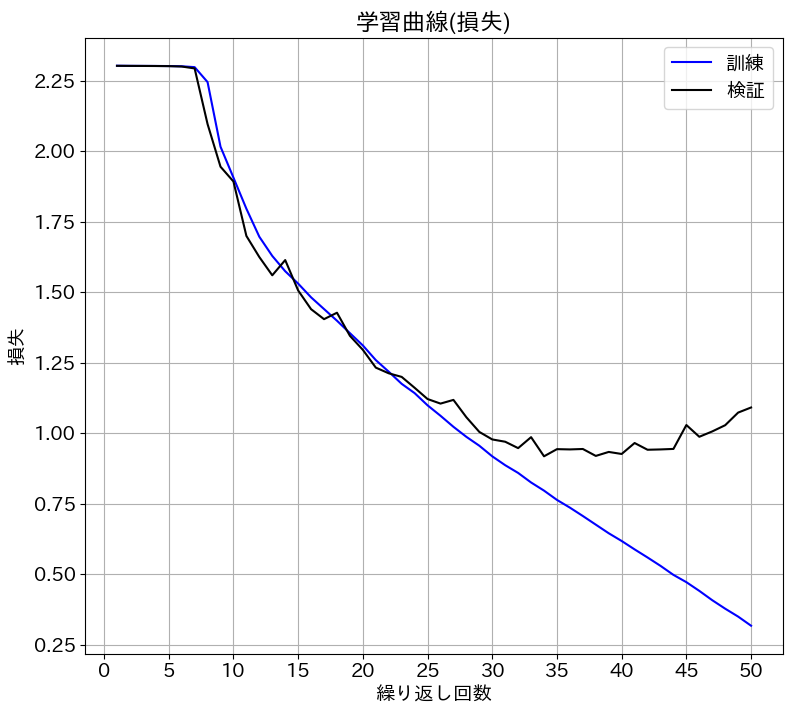

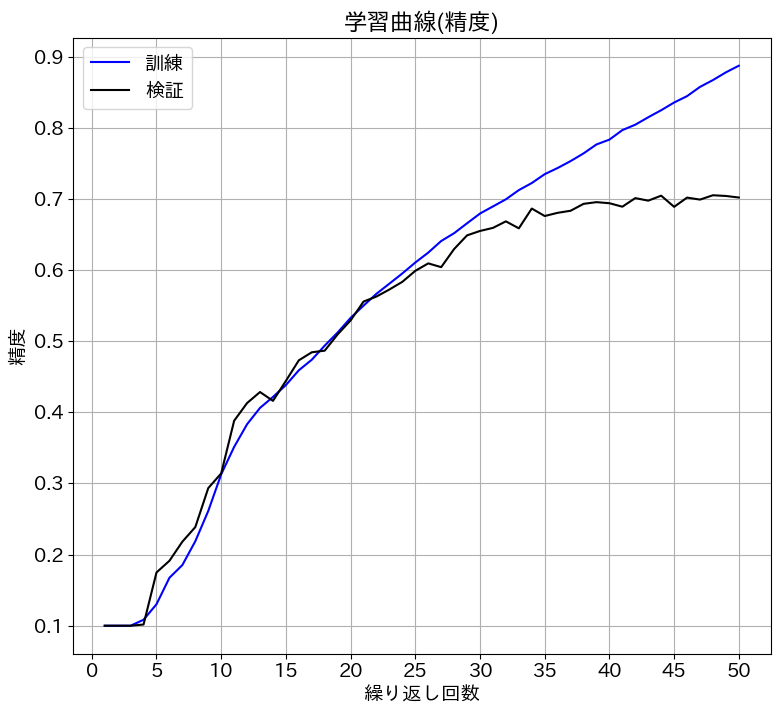

In [121]:
evaluate_history(history)

## 10.7 最適化関数の選択

### momentumの設定

In [122]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にmomentumを指定
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

In [123]:
# momentumで学習

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

100%|██████████| 500/500 [00:12<00:00, 40.27it/s]


Epoch [1/20], loss: 2.28245 acc: 0.12320 val_loss: 2.03961, val_acc: 0.25310


100%|██████████| 500/500 [00:12<00:00, 40.15it/s]


Epoch [2/20], loss: 1.79610 acc: 0.33772 val_loss: 1.53967, val_acc: 0.42580


100%|██████████| 500/500 [00:12<00:00, 40.98it/s]


Epoch [3/20], loss: 1.40959 acc: 0.48270 val_loss: 1.28068, val_acc: 0.53850


100%|██████████| 500/500 [00:12<00:00, 40.88it/s]


Epoch [4/20], loss: 1.16003 acc: 0.58486 val_loss: 1.11728, val_acc: 0.60100


100%|██████████| 500/500 [00:12<00:00, 40.97it/s]


Epoch [5/20], loss: 0.97009 acc: 0.65522 val_loss: 0.93222, val_acc: 0.66760


100%|██████████| 500/500 [00:12<00:00, 40.00it/s]


Epoch [6/20], loss: 0.81615 acc: 0.71178 val_loss: 0.83312, val_acc: 0.70900


100%|██████████| 500/500 [00:12<00:00, 39.49it/s]


Epoch [7/20], loss: 0.68640 acc: 0.75926 val_loss: 0.76700, val_acc: 0.73180


100%|██████████| 500/500 [00:12<00:00, 41.66it/s]


Epoch [8/20], loss: 0.57916 acc: 0.79682 val_loss: 0.72232, val_acc: 0.75770


100%|██████████| 500/500 [00:12<00:00, 40.37it/s]


Epoch [9/20], loss: 0.48913 acc: 0.82890 val_loss: 0.72274, val_acc: 0.75440


100%|██████████| 500/500 [00:12<00:00, 41.50it/s]


Epoch [10/20], loss: 0.41287 acc: 0.85436 val_loss: 0.73850, val_acc: 0.75810


100%|██████████| 500/500 [00:12<00:00, 40.93it/s]


Epoch [11/20], loss: 0.34279 acc: 0.87914 val_loss: 0.79870, val_acc: 0.75820


100%|██████████| 500/500 [00:12<00:00, 40.08it/s]


Epoch [12/20], loss: 0.28047 acc: 0.89884 val_loss: 0.80950, val_acc: 0.76950


100%|██████████| 500/500 [00:12<00:00, 40.68it/s]


Epoch [13/20], loss: 0.22663 acc: 0.91878 val_loss: 0.90737, val_acc: 0.75800


100%|██████████| 500/500 [00:11<00:00, 41.96it/s]


Epoch [14/20], loss: 0.19403 acc: 0.92986 val_loss: 0.97987, val_acc: 0.76080


100%|██████████| 500/500 [00:11<00:00, 41.71it/s]


Epoch [15/20], loss: 0.16209 acc: 0.94176 val_loss: 0.97421, val_acc: 0.76100


100%|██████████| 500/500 [00:12<00:00, 39.58it/s]


Epoch [16/20], loss: 0.13483 acc: 0.95216 val_loss: 1.05043, val_acc: 0.76390


100%|██████████| 500/500 [00:12<00:00, 38.83it/s]


Epoch [17/20], loss: 0.11640 acc: 0.95866 val_loss: 1.19089, val_acc: 0.76110


100%|██████████| 500/500 [00:11<00:00, 41.82it/s]


Epoch [18/20], loss: 0.10777 acc: 0.96186 val_loss: 1.15547, val_acc: 0.76530


100%|██████████| 500/500 [00:12<00:00, 40.50it/s]


Epoch [19/20], loss: 0.09515 acc: 0.96684 val_loss: 1.24030, val_acc: 0.77090


100%|██████████| 500/500 [00:12<00:00, 40.34it/s]


Epoch [20/20], loss: 0.08502 acc: 0.96998 val_loss: 1.32260, val_acc: 0.75970


初期状態: 損失: 2.03961 精度: 0.25310
最終状態: 損失: 1.32260 精度: 0.75970


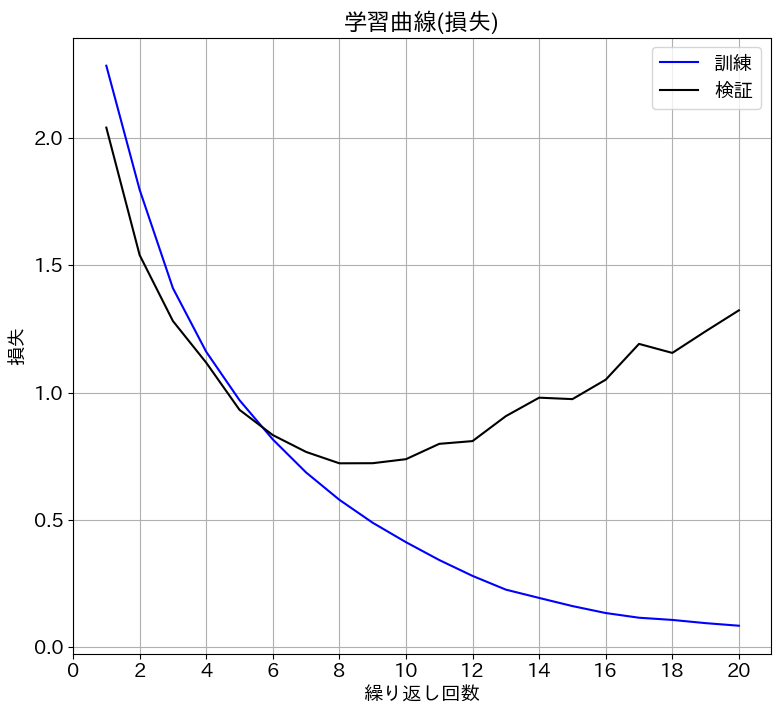

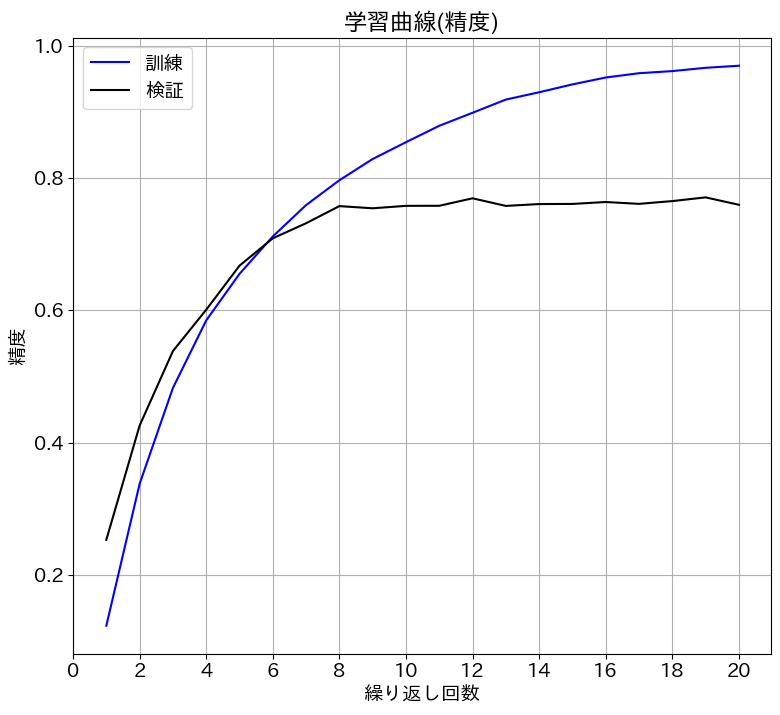

In [124]:
evaluate_history(history2)

### Adamの利用

In [125]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にAdamを指定
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [126]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [127]:
# 学習

num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

100%|██████████| 500/500 [00:12<00:00, 39.01it/s]


Epoch [1/20], loss: 1.59602 acc: 0.41644 val_loss: 1.27277, val_acc: 0.54200


100%|██████████| 500/500 [00:13<00:00, 38.34it/s]


Epoch [2/20], loss: 1.10147 acc: 0.60458 val_loss: 1.05257, val_acc: 0.62670


100%|██████████| 500/500 [00:12<00:00, 38.97it/s]


Epoch [3/20], loss: 0.88081 acc: 0.69024 val_loss: 0.87619, val_acc: 0.69950


100%|██████████| 500/500 [00:12<00:00, 38.77it/s]


Epoch [4/20], loss: 0.72402 acc: 0.74392 val_loss: 0.78082, val_acc: 0.73140


100%|██████████| 500/500 [00:13<00:00, 38.33it/s]


Epoch [5/20], loss: 0.61103 acc: 0.78442 val_loss: 0.72146, val_acc: 0.75550


100%|██████████| 500/500 [00:12<00:00, 39.27it/s]


Epoch [6/20], loss: 0.52060 acc: 0.81718 val_loss: 0.74476, val_acc: 0.75500


100%|██████████| 500/500 [00:12<00:00, 40.67it/s]


Epoch [7/20], loss: 0.43107 acc: 0.84794 val_loss: 0.74992, val_acc: 0.75940


100%|██████████| 500/500 [00:12<00:00, 39.08it/s]


Epoch [8/20], loss: 0.36496 acc: 0.87170 val_loss: 0.76862, val_acc: 0.76900


100%|██████████| 500/500 [00:12<00:00, 40.54it/s]


Epoch [9/20], loss: 0.29078 acc: 0.89706 val_loss: 0.81022, val_acc: 0.76650


100%|██████████| 500/500 [00:12<00:00, 38.48it/s]


Epoch [10/20], loss: 0.23250 acc: 0.91756 val_loss: 0.90773, val_acc: 0.75820


100%|██████████| 500/500 [00:13<00:00, 36.17it/s]


Epoch [11/20], loss: 0.18831 acc: 0.93328 val_loss: 0.96053, val_acc: 0.75920


100%|██████████| 500/500 [00:12<00:00, 39.93it/s]


Epoch [12/20], loss: 0.16051 acc: 0.94256 val_loss: 1.08255, val_acc: 0.75830


100%|██████████| 500/500 [00:13<00:00, 38.33it/s]


Epoch [13/20], loss: 0.14566 acc: 0.94732 val_loss: 1.12174, val_acc: 0.76350


100%|██████████| 500/500 [00:12<00:00, 39.37it/s]


Epoch [14/20], loss: 0.12198 acc: 0.95606 val_loss: 1.16289, val_acc: 0.76190


100%|██████████| 500/500 [00:12<00:00, 39.50it/s]


Epoch [15/20], loss: 0.11434 acc: 0.95972 val_loss: 1.31943, val_acc: 0.76250


100%|██████████| 500/500 [00:12<00:00, 38.59it/s]


Epoch [16/20], loss: 0.10361 acc: 0.96390 val_loss: 1.37085, val_acc: 0.76190


100%|██████████| 500/500 [00:12<00:00, 40.02it/s]


Epoch [17/20], loss: 0.10196 acc: 0.96440 val_loss: 1.28423, val_acc: 0.75300


100%|██████████| 500/500 [00:12<00:00, 40.05it/s]


Epoch [18/20], loss: 0.09184 acc: 0.96842 val_loss: 1.39609, val_acc: 0.75390


100%|██████████| 500/500 [00:13<00:00, 37.77it/s]


Epoch [19/20], loss: 0.08382 acc: 0.97030 val_loss: 1.39042, val_acc: 0.76280


100%|██████████| 500/500 [00:13<00:00, 37.34it/s]


Epoch [20/20], loss: 0.08366 acc: 0.97130 val_loss: 1.47133, val_acc: 0.75590


初期状態: 損失: 1.27277 精度: 0.54200
最終状態: 損失: 1.47133 精度: 0.75590


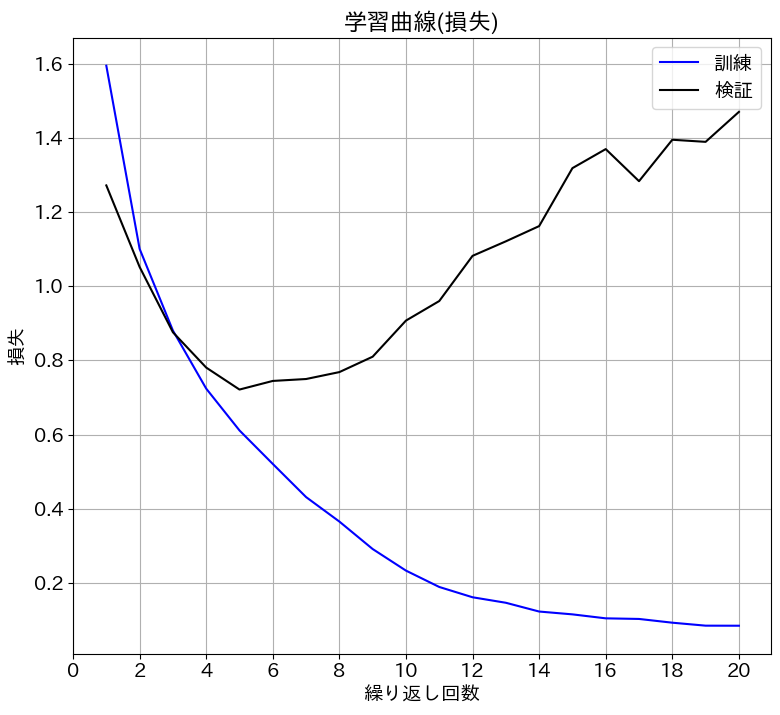

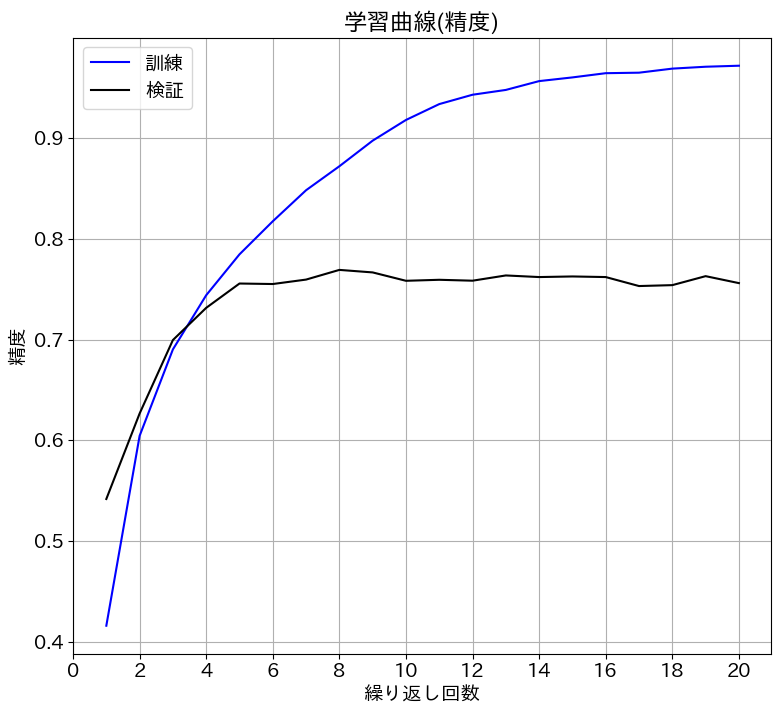

In [128]:
evaluate_history(history3)

### 結果比較

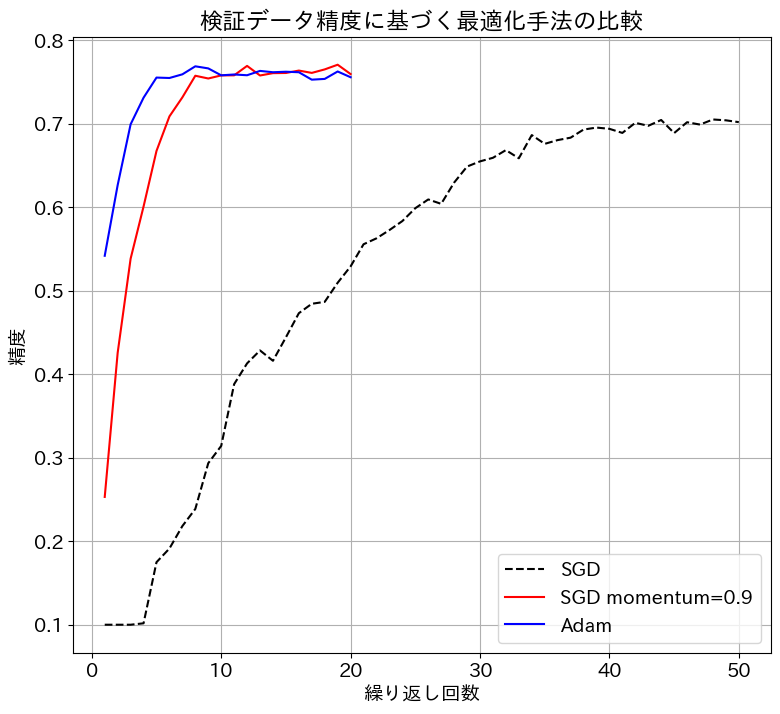

In [129]:
# 結果の比較(検証データへの精度)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,4], label='SGD', c='k',ls='dashed' )
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9', c='r')
plt.plot(history3[:,0], history3[:,4], label='Adam', c='b')
"""
plt.title('Comparison of optimizers in accuracy on test data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
"""
plt.title('検証データ精度に基づく最適化手法の比較')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.legend()
plt.show()

## 10.8 ドロップアウト

In [71]:
# 予測クラスの定義

class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

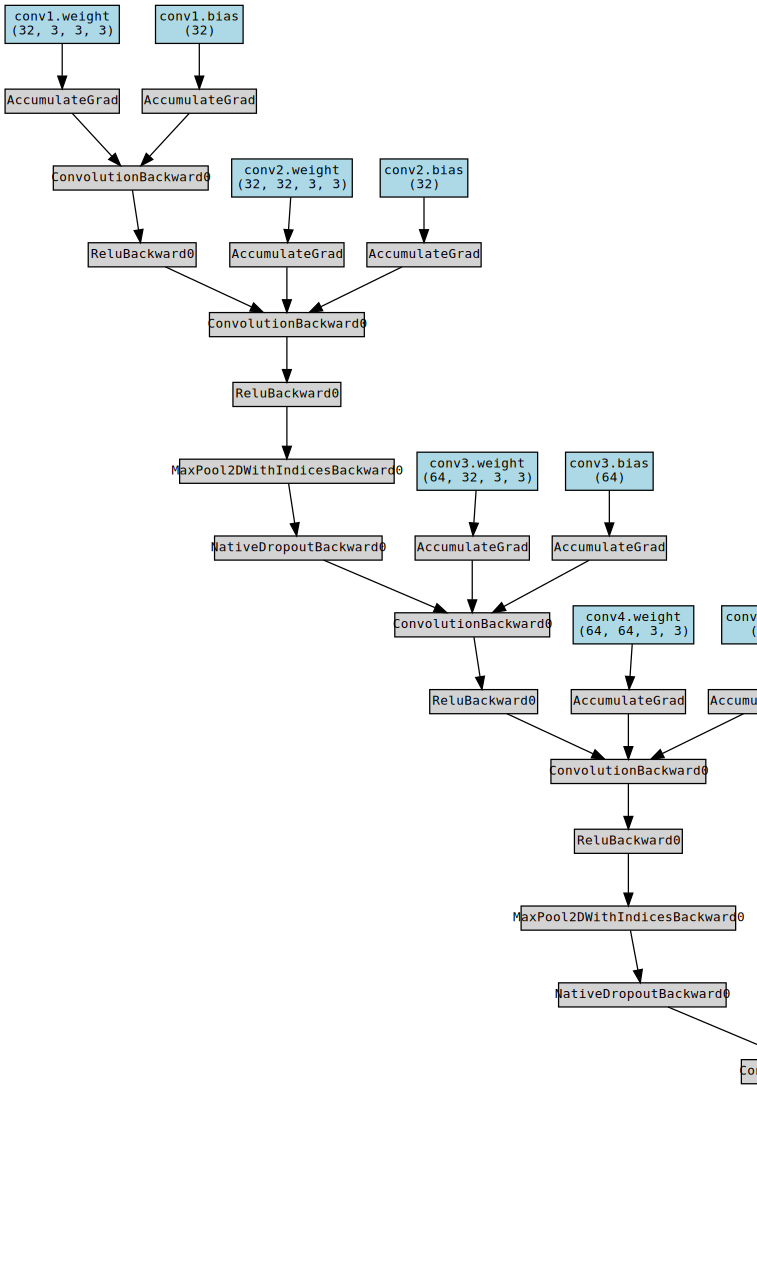

In [72]:
# 損失関数のグラフ表示
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [73]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [74]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

100%|██████████| 500/500 [00:13<00:00, 37.78it/s]


Epoch [1/50], loss: 1.75456 acc: 0.34706 val_loss: 1.36290, val_acc: 0.49050


100%|██████████| 500/500 [00:12<00:00, 38.63it/s]


Epoch [2/50], loss: 1.32075 acc: 0.51828 val_loss: 1.10043, val_acc: 0.59920


100%|██████████| 500/500 [00:13<00:00, 38.20it/s]


Epoch [3/50], loss: 1.14887 acc: 0.58910 val_loss: 0.97515, val_acc: 0.65400


100%|██████████| 500/500 [00:13<00:00, 37.63it/s]


Epoch [4/50], loss: 1.01613 acc: 0.64084 val_loss: 0.88514, val_acc: 0.68740


100%|██████████| 500/500 [00:13<00:00, 37.55it/s]


Epoch [5/50], loss: 0.92445 acc: 0.67666 val_loss: 0.79671, val_acc: 0.72010


100%|██████████| 500/500 [00:12<00:00, 39.19it/s]


Epoch [6/50], loss: 0.85877 acc: 0.70236 val_loss: 0.74301, val_acc: 0.74180


100%|██████████| 500/500 [00:13<00:00, 38.08it/s]


Epoch [7/50], loss: 0.79868 acc: 0.72034 val_loss: 0.72526, val_acc: 0.75090


100%|██████████| 500/500 [00:12<00:00, 39.03it/s]


Epoch [8/50], loss: 0.76563 acc: 0.73544 val_loss: 0.68729, val_acc: 0.76630


100%|██████████| 500/500 [00:13<00:00, 38.27it/s]


Epoch [9/50], loss: 0.72544 acc: 0.74890 val_loss: 0.66687, val_acc: 0.76920


100%|██████████| 500/500 [00:13<00:00, 37.26it/s]


Epoch [10/50], loss: 0.69819 acc: 0.75744 val_loss: 0.66274, val_acc: 0.77300


100%|██████████| 500/500 [00:13<00:00, 37.38it/s]


Epoch [11/50], loss: 0.67804 acc: 0.76632 val_loss: 0.63727, val_acc: 0.78250


100%|██████████| 500/500 [00:13<00:00, 38.33it/s]


Epoch [12/50], loss: 0.65373 acc: 0.77260 val_loss: 0.61047, val_acc: 0.79420


100%|██████████| 500/500 [00:13<00:00, 37.98it/s]


Epoch [13/50], loss: 0.62956 acc: 0.78218 val_loss: 0.61144, val_acc: 0.78880


100%|██████████| 500/500 [00:13<00:00, 37.56it/s]


Epoch [14/50], loss: 0.61830 acc: 0.78542 val_loss: 0.59332, val_acc: 0.80020


100%|██████████| 500/500 [00:12<00:00, 39.16it/s]


Epoch [15/50], loss: 0.59744 acc: 0.79330 val_loss: 0.59878, val_acc: 0.79760


100%|██████████| 500/500 [00:13<00:00, 37.49it/s]


Epoch [16/50], loss: 0.57820 acc: 0.80042 val_loss: 0.58007, val_acc: 0.80530


100%|██████████| 500/500 [00:13<00:00, 37.49it/s]


Epoch [17/50], loss: 0.57668 acc: 0.80056 val_loss: 0.58863, val_acc: 0.80350


100%|██████████| 500/500 [00:13<00:00, 36.98it/s]


Epoch [18/50], loss: 0.56497 acc: 0.80492 val_loss: 0.56094, val_acc: 0.80890


100%|██████████| 500/500 [00:13<00:00, 36.98it/s]


Epoch [19/50], loss: 0.54467 acc: 0.81100 val_loss: 0.55518, val_acc: 0.81710


100%|██████████| 500/500 [00:13<00:00, 38.41it/s]


Epoch [20/50], loss: 0.54852 acc: 0.80994 val_loss: 0.55784, val_acc: 0.81440


100%|██████████| 500/500 [00:13<00:00, 38.19it/s]


Epoch [21/50], loss: 0.52985 acc: 0.81610 val_loss: 0.55800, val_acc: 0.81530


100%|██████████| 500/500 [00:13<00:00, 36.61it/s]


Epoch [22/50], loss: 0.51925 acc: 0.81908 val_loss: 0.57177, val_acc: 0.81570


100%|██████████| 500/500 [00:13<00:00, 37.93it/s]


Epoch [23/50], loss: 0.51626 acc: 0.81946 val_loss: 0.55929, val_acc: 0.81610


100%|██████████| 500/500 [00:13<00:00, 36.99it/s]


Epoch [24/50], loss: 0.50882 acc: 0.82366 val_loss: 0.57793, val_acc: 0.80840


100%|██████████| 500/500 [00:13<00:00, 37.23it/s]


Epoch [25/50], loss: 0.50019 acc: 0.82684 val_loss: 0.54889, val_acc: 0.82320


100%|██████████| 500/500 [00:13<00:00, 38.04it/s]


Epoch [26/50], loss: 0.49500 acc: 0.82692 val_loss: 0.54831, val_acc: 0.81740


100%|██████████| 500/500 [00:13<00:00, 36.78it/s]


Epoch [27/50], loss: 0.49049 acc: 0.83066 val_loss: 0.56373, val_acc: 0.81640


100%|██████████| 500/500 [00:13<00:00, 36.47it/s]


Epoch [28/50], loss: 0.48760 acc: 0.83238 val_loss: 0.54927, val_acc: 0.82220


100%|██████████| 500/500 [00:13<00:00, 38.01it/s]


Epoch [29/50], loss: 0.47550 acc: 0.83630 val_loss: 0.54515, val_acc: 0.82370


100%|██████████| 500/500 [00:13<00:00, 37.12it/s]


Epoch [30/50], loss: 0.47182 acc: 0.83452 val_loss: 0.54956, val_acc: 0.82310


100%|██████████| 500/500 [00:13<00:00, 37.72it/s]


Epoch [31/50], loss: 0.46893 acc: 0.83816 val_loss: 0.53856, val_acc: 0.82610


100%|██████████| 500/500 [00:13<00:00, 37.39it/s]


Epoch [32/50], loss: 0.45915 acc: 0.84150 val_loss: 0.55678, val_acc: 0.82300


100%|██████████| 500/500 [00:13<00:00, 37.39it/s]


Epoch [33/50], loss: 0.45832 acc: 0.84090 val_loss: 0.53209, val_acc: 0.82950


100%|██████████| 500/500 [00:13<00:00, 37.39it/s]


Epoch [34/50], loss: 0.45119 acc: 0.84490 val_loss: 0.54045, val_acc: 0.82560


100%|██████████| 500/500 [00:13<00:00, 37.98it/s]


Epoch [35/50], loss: 0.45374 acc: 0.84330 val_loss: 0.53843, val_acc: 0.82110


100%|██████████| 500/500 [00:13<00:00, 37.54it/s]


Epoch [36/50], loss: 0.45060 acc: 0.84308 val_loss: 0.54764, val_acc: 0.82570


100%|██████████| 500/500 [00:13<00:00, 38.07it/s]


Epoch [37/50], loss: 0.44027 acc: 0.84726 val_loss: 0.52248, val_acc: 0.82880


100%|██████████| 500/500 [00:13<00:00, 37.20it/s]


Epoch [38/50], loss: 0.43850 acc: 0.84778 val_loss: 0.52654, val_acc: 0.83320


100%|██████████| 500/500 [00:13<00:00, 37.05it/s]


Epoch [39/50], loss: 0.42777 acc: 0.85242 val_loss: 0.52452, val_acc: 0.83310


100%|██████████| 500/500 [00:13<00:00, 38.12it/s]


Epoch [40/50], loss: 0.42692 acc: 0.85160 val_loss: 0.52017, val_acc: 0.83130


100%|██████████| 500/500 [00:13<00:00, 38.19it/s]


Epoch [41/50], loss: 0.42599 acc: 0.85390 val_loss: 0.53970, val_acc: 0.82460


100%|██████████| 500/500 [00:13<00:00, 37.54it/s]


Epoch [42/50], loss: 0.42363 acc: 0.85192 val_loss: 0.52121, val_acc: 0.83300


100%|██████████| 500/500 [00:13<00:00, 37.55it/s]


Epoch [43/50], loss: 0.41848 acc: 0.85340 val_loss: 0.52739, val_acc: 0.83570


100%|██████████| 500/500 [00:13<00:00, 38.21it/s]


Epoch [44/50], loss: 0.42251 acc: 0.85292 val_loss: 0.53520, val_acc: 0.83330


100%|██████████| 500/500 [00:13<00:00, 37.53it/s]


Epoch [45/50], loss: 0.41606 acc: 0.85404 val_loss: 0.53276, val_acc: 0.83330


100%|██████████| 500/500 [00:13<00:00, 37.03it/s]


Epoch [46/50], loss: 0.41303 acc: 0.85692 val_loss: 0.53058, val_acc: 0.83030


100%|██████████| 500/500 [00:13<00:00, 38.44it/s]


Epoch [47/50], loss: 0.41361 acc: 0.85776 val_loss: 0.53156, val_acc: 0.83360


100%|██████████| 500/500 [00:13<00:00, 37.90it/s]


Epoch [48/50], loss: 0.40991 acc: 0.85766 val_loss: 0.52851, val_acc: 0.83490


100%|██████████| 500/500 [00:13<00:00, 38.09it/s]


Epoch [49/50], loss: 0.40633 acc: 0.85774 val_loss: 0.52752, val_acc: 0.83430


100%|██████████| 500/500 [00:13<00:00, 38.19it/s]


Epoch [50/50], loss: 0.40449 acc: 0.85956 val_loss: 0.55117, val_acc: 0.83220


初期状態: 損失: 1.36290 精度: 0.49050
最終状態: 損失: 0.55117 精度: 0.83220


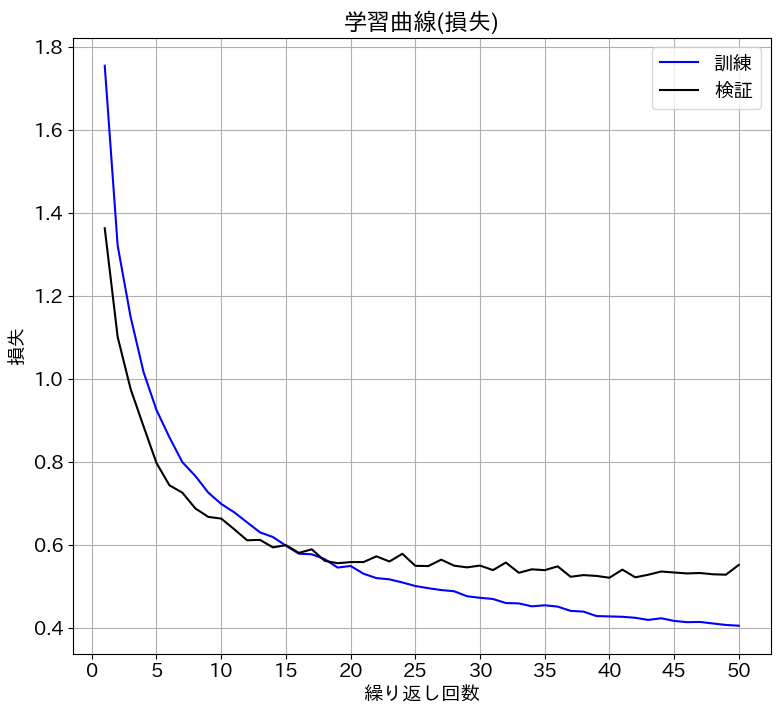

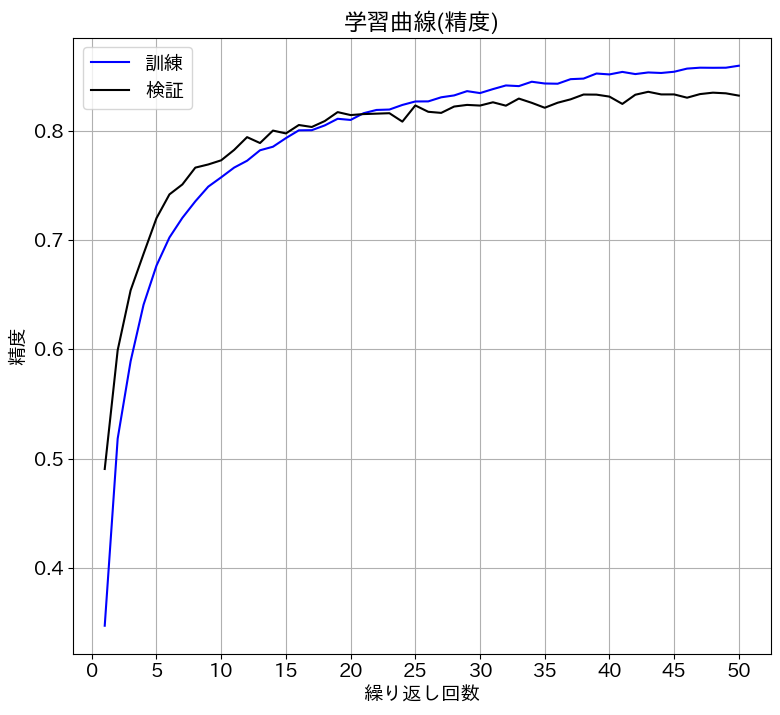

In [75]:
evaluate_history(history)

## 10.9 Batch Normalization

In [76]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [77]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [78]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

100%|██████████| 500/500 [00:14<00:00, 34.07it/s]


Epoch [1/50], loss: 1.50308 acc: 0.44668 val_loss: 1.12196, val_acc: 0.59000


100%|██████████| 500/500 [00:14<00:00, 34.38it/s]


Epoch [2/50], loss: 1.12891 acc: 0.59364 val_loss: 1.18173, val_acc: 0.60110


100%|██████████| 500/500 [00:14<00:00, 34.04it/s]


Epoch [3/50], loss: 0.98436 acc: 0.65242 val_loss: 0.80497, val_acc: 0.71570


100%|██████████| 500/500 [00:14<00:00, 34.67it/s]


Epoch [4/50], loss: 0.89279 acc: 0.68974 val_loss: 0.74416, val_acc: 0.74060


100%|██████████| 500/500 [00:14<00:00, 35.40it/s]


Epoch [5/50], loss: 0.82681 acc: 0.71498 val_loss: 0.77692, val_acc: 0.73240


100%|██████████| 500/500 [00:14<00:00, 35.15it/s]


Epoch [6/50], loss: 0.77248 acc: 0.73416 val_loss: 0.71749, val_acc: 0.74930


100%|██████████| 500/500 [00:14<00:00, 33.68it/s]


Epoch [7/50], loss: 0.72795 acc: 0.74756 val_loss: 0.61456, val_acc: 0.78550


100%|██████████| 500/500 [00:14<00:00, 34.22it/s]


Epoch [8/50], loss: 0.69052 acc: 0.76224 val_loss: 0.67426, val_acc: 0.76950


100%|██████████| 500/500 [00:13<00:00, 35.75it/s]


Epoch [9/50], loss: 0.66012 acc: 0.77528 val_loss: 0.55531, val_acc: 0.81080


100%|██████████| 500/500 [00:14<00:00, 33.86it/s]


Epoch [10/50], loss: 0.63414 acc: 0.78604 val_loss: 0.57875, val_acc: 0.80410


100%|██████████| 500/500 [00:14<00:00, 34.84it/s]


Epoch [11/50], loss: 0.60054 acc: 0.79580 val_loss: 0.56707, val_acc: 0.80960


100%|██████████| 500/500 [00:14<00:00, 33.73it/s]


Epoch [12/50], loss: 0.57597 acc: 0.80470 val_loss: 0.51482, val_acc: 0.82670


100%|██████████| 500/500 [00:14<00:00, 34.92it/s]


Epoch [13/50], loss: 0.55468 acc: 0.81138 val_loss: 0.53253, val_acc: 0.82180


100%|██████████| 500/500 [00:14<00:00, 34.89it/s]


Epoch [14/50], loss: 0.53455 acc: 0.81820 val_loss: 0.50704, val_acc: 0.82860


100%|██████████| 500/500 [00:14<00:00, 33.84it/s]


Epoch [15/50], loss: 0.51803 acc: 0.82558 val_loss: 0.49780, val_acc: 0.83700


100%|██████████| 500/500 [00:14<00:00, 35.05it/s]


Epoch [16/50], loss: 0.50136 acc: 0.82896 val_loss: 0.48150, val_acc: 0.84190


100%|██████████| 500/500 [00:14<00:00, 34.80it/s]


Epoch [17/50], loss: 0.47860 acc: 0.83798 val_loss: 0.48810, val_acc: 0.83790


100%|██████████| 500/500 [00:14<00:00, 34.72it/s]


Epoch [18/50], loss: 0.47077 acc: 0.84046 val_loss: 0.47952, val_acc: 0.84040


100%|██████████| 500/500 [00:14<00:00, 34.48it/s]


Epoch [19/50], loss: 0.45542 acc: 0.84750 val_loss: 0.48453, val_acc: 0.83950


100%|██████████| 500/500 [00:14<00:00, 35.28it/s]


Epoch [20/50], loss: 0.45009 acc: 0.84866 val_loss: 0.47657, val_acc: 0.84610


100%|██████████| 500/500 [00:14<00:00, 34.82it/s]


Epoch [21/50], loss: 0.43160 acc: 0.85528 val_loss: 0.44378, val_acc: 0.85390


100%|██████████| 500/500 [00:14<00:00, 34.29it/s]


Epoch [22/50], loss: 0.41944 acc: 0.85850 val_loss: 0.48742, val_acc: 0.84530


100%|██████████| 500/500 [00:14<00:00, 35.55it/s]


Epoch [23/50], loss: 0.40777 acc: 0.86132 val_loss: 0.49221, val_acc: 0.84180


100%|██████████| 500/500 [00:13<00:00, 35.76it/s]


Epoch [24/50], loss: 0.40012 acc: 0.86426 val_loss: 0.45694, val_acc: 0.85700


100%|██████████| 500/500 [00:15<00:00, 32.17it/s]


Epoch [25/50], loss: 0.38953 acc: 0.86916 val_loss: 0.43563, val_acc: 0.85780


100%|██████████| 500/500 [00:15<00:00, 33.21it/s]


Epoch [26/50], loss: 0.38018 acc: 0.87260 val_loss: 0.44805, val_acc: 0.85700


100%|██████████| 500/500 [00:14<00:00, 33.93it/s]


Epoch [27/50], loss: 0.37212 acc: 0.87444 val_loss: 0.45522, val_acc: 0.85490


100%|██████████| 500/500 [00:14<00:00, 34.56it/s]


Epoch [28/50], loss: 0.37119 acc: 0.87490 val_loss: 0.46221, val_acc: 0.85610


100%|██████████| 500/500 [00:15<00:00, 32.95it/s]


Epoch [29/50], loss: 0.35953 acc: 0.87882 val_loss: 0.44096, val_acc: 0.86270


100%|██████████| 500/500 [00:15<00:00, 33.32it/s]


Epoch [30/50], loss: 0.34781 acc: 0.88146 val_loss: 0.44743, val_acc: 0.86100


100%|██████████| 500/500 [00:14<00:00, 34.16it/s]


Epoch [31/50], loss: 0.34213 acc: 0.88418 val_loss: 0.45053, val_acc: 0.86100


100%|██████████| 500/500 [00:14<00:00, 33.99it/s]


Epoch [32/50], loss: 0.34346 acc: 0.88496 val_loss: 0.43465, val_acc: 0.86080


100%|██████████| 500/500 [00:15<00:00, 32.72it/s]


Epoch [33/50], loss: 0.33142 acc: 0.88720 val_loss: 0.42476, val_acc: 0.86620


100%|██████████| 500/500 [00:14<00:00, 35.11it/s]


Epoch [34/50], loss: 0.32400 acc: 0.89052 val_loss: 0.43858, val_acc: 0.86440


100%|██████████| 500/500 [00:14<00:00, 35.08it/s]


Epoch [35/50], loss: 0.31217 acc: 0.89388 val_loss: 0.46448, val_acc: 0.85870


100%|██████████| 500/500 [00:14<00:00, 34.53it/s]


Epoch [36/50], loss: 0.30754 acc: 0.89484 val_loss: 0.46523, val_acc: 0.85820


100%|██████████| 500/500 [00:13<00:00, 35.83it/s]


Epoch [37/50], loss: 0.30241 acc: 0.89698 val_loss: 0.44580, val_acc: 0.86340


100%|██████████| 500/500 [00:14<00:00, 34.20it/s]


Epoch [38/50], loss: 0.29907 acc: 0.89818 val_loss: 0.46948, val_acc: 0.85840


100%|██████████| 500/500 [00:14<00:00, 35.16it/s]


Epoch [39/50], loss: 0.28861 acc: 0.90172 val_loss: 0.44036, val_acc: 0.86390


100%|██████████| 500/500 [00:14<00:00, 35.48it/s]


Epoch [40/50], loss: 0.28960 acc: 0.89960 val_loss: 0.44589, val_acc: 0.86460


100%|██████████| 500/500 [00:14<00:00, 35.62it/s]


Epoch [41/50], loss: 0.28432 acc: 0.90320 val_loss: 0.43444, val_acc: 0.86770


100%|██████████| 500/500 [00:14<00:00, 35.22it/s]


Epoch [42/50], loss: 0.27922 acc: 0.90470 val_loss: 0.45119, val_acc: 0.86280


100%|██████████| 500/500 [00:14<00:00, 33.94it/s]


Epoch [43/50], loss: 0.28022 acc: 0.90406 val_loss: 0.45102, val_acc: 0.86890


100%|██████████| 500/500 [00:14<00:00, 35.43it/s]


Epoch [44/50], loss: 0.26982 acc: 0.90754 val_loss: 0.46619, val_acc: 0.86460


100%|██████████| 500/500 [00:14<00:00, 35.03it/s]


Epoch [45/50], loss: 0.26956 acc: 0.90754 val_loss: 0.44529, val_acc: 0.86960


100%|██████████| 500/500 [00:14<00:00, 33.92it/s]


Epoch [46/50], loss: 0.26606 acc: 0.90910 val_loss: 0.45770, val_acc: 0.86130


100%|██████████| 500/500 [00:14<00:00, 35.69it/s]


Epoch [47/50], loss: 0.26091 acc: 0.90874 val_loss: 0.45513, val_acc: 0.86490


100%|██████████| 500/500 [00:14<00:00, 34.86it/s]


Epoch [48/50], loss: 0.26007 acc: 0.91062 val_loss: 0.45860, val_acc: 0.86510


100%|██████████| 500/500 [00:13<00:00, 35.79it/s]


Epoch [49/50], loss: 0.25004 acc: 0.91248 val_loss: 0.45965, val_acc: 0.86420


100%|██████████| 500/500 [00:14<00:00, 35.27it/s]


Epoch [50/50], loss: 0.24887 acc: 0.91460 val_loss: 0.45399, val_acc: 0.86650


初期状態: 損失: 1.12196 精度: 0.59000
最終状態: 損失: 0.45399 精度: 0.86650


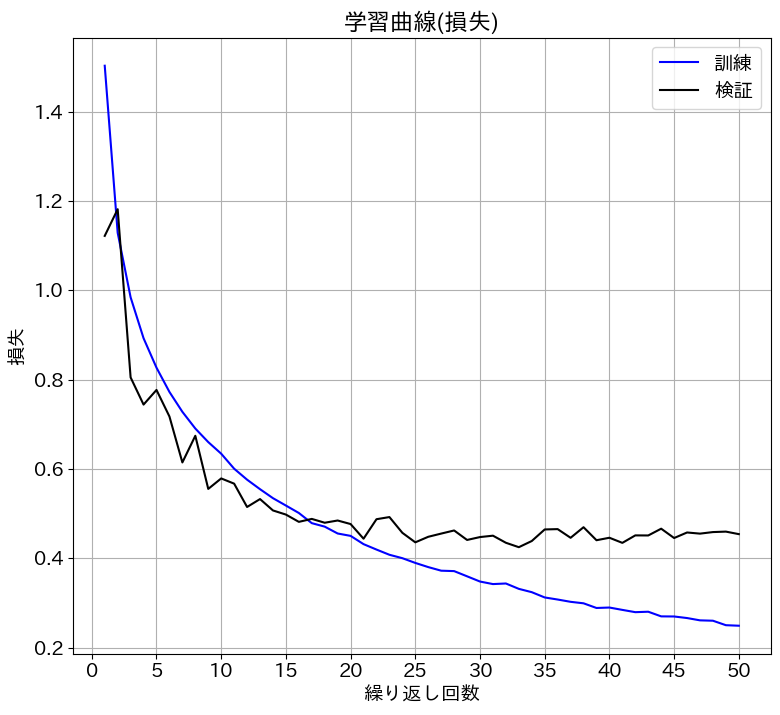

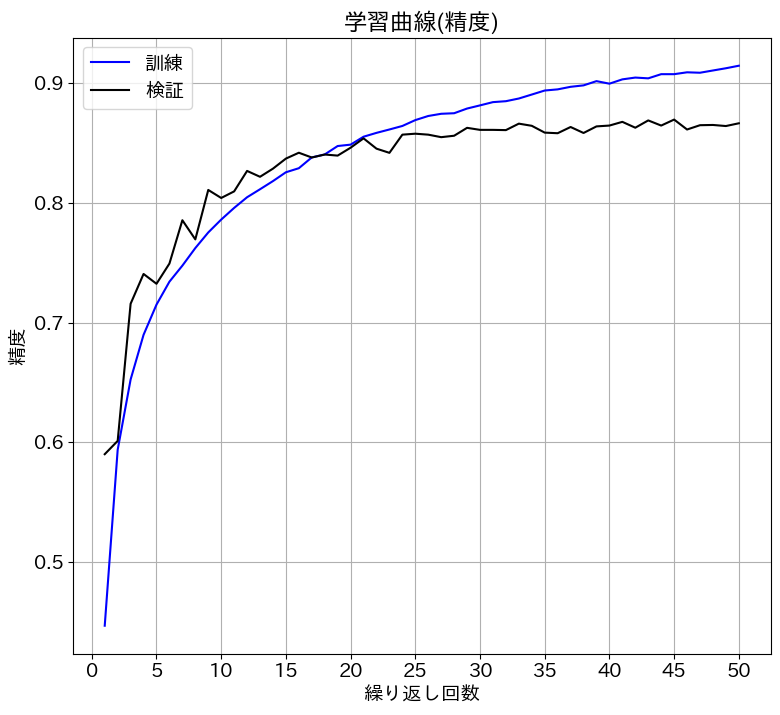

In [79]:
evaluate_history(history)

## 10.10 Data Augmentation

In [80]:
# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [81]:
# transfrom_trainを利用したデータセットの定義
train_set2 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform_train)

# traisform_trainを利用したデータローダーの定義
batch_size = 100
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


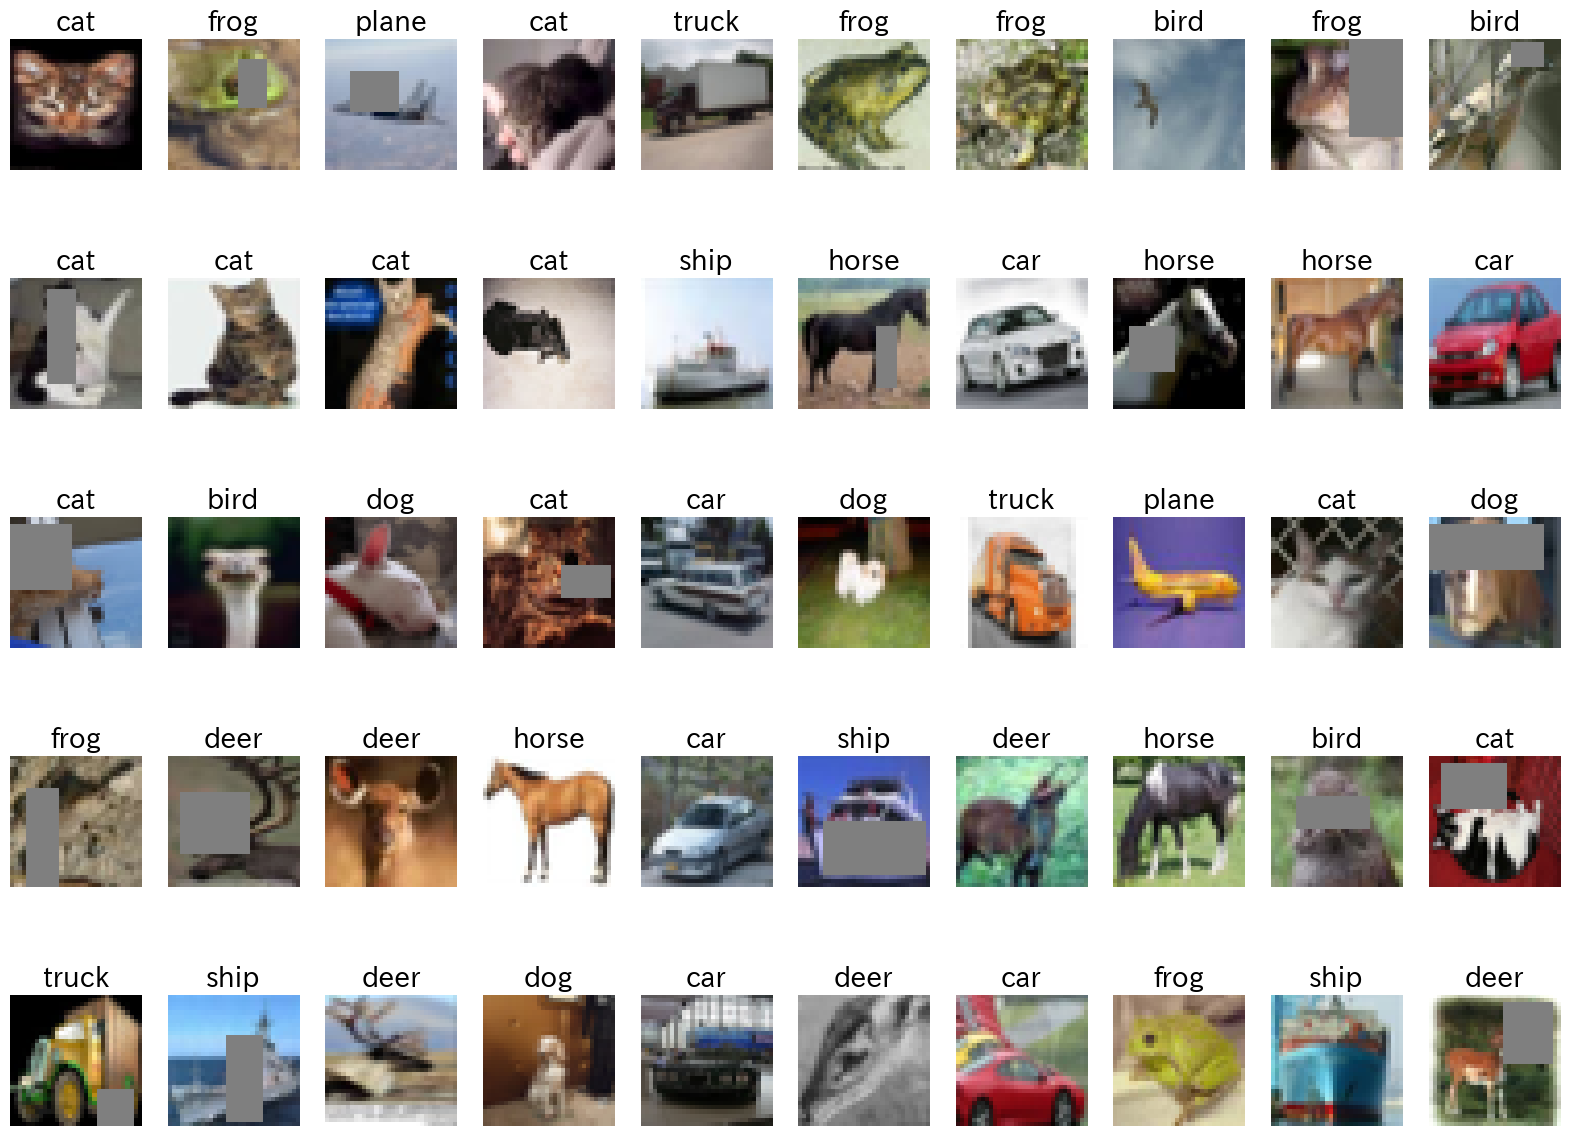

In [82]:
# 新しい訓練用データの先頭50個を表示してみる

# 乱数初期化
torch_seed()

show_images_labels(train_loader2, classes, None, None)

In [83]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [84]:
# 学習
# 同じモデルでtrain_loader2に変更

num_epochs = 100
history = fit(net, optimizer, criterion, num_epochs, 
        train_loader2, test_loader, device, history)

100%|██████████| 500/500 [00:19<00:00, 26.17it/s]


Epoch [1/100], loss: 1.59461 acc: 0.41278 val_loss: 1.41714, val_acc: 0.50790


100%|██████████| 500/500 [00:18<00:00, 26.62it/s]


Epoch [2/100], loss: 1.27726 acc: 0.54192 val_loss: 0.97873, val_acc: 0.64760


100%|██████████| 500/500 [00:18<00:00, 26.36it/s]


Epoch [3/100], loss: 1.13956 acc: 0.59362 val_loss: 0.85517, val_acc: 0.69010


100%|██████████| 500/500 [00:18<00:00, 26.38it/s]


Epoch [4/100], loss: 1.06260 acc: 0.62766 val_loss: 0.84568, val_acc: 0.69620


100%|██████████| 500/500 [00:18<00:00, 26.68it/s]


Epoch [5/100], loss: 0.99362 acc: 0.65520 val_loss: 0.75923, val_acc: 0.73150


100%|██████████| 500/500 [00:19<00:00, 26.22it/s]


Epoch [6/100], loss: 0.95248 acc: 0.67006 val_loss: 0.73186, val_acc: 0.73880


100%|██████████| 500/500 [00:18<00:00, 26.35it/s]


Epoch [7/100], loss: 0.92099 acc: 0.68168 val_loss: 0.69770, val_acc: 0.75240


100%|██████████| 500/500 [00:19<00:00, 25.71it/s]


Epoch [8/100], loss: 0.88052 acc: 0.69860 val_loss: 0.75834, val_acc: 0.73370


100%|██████████| 500/500 [00:19<00:00, 26.16it/s]


Epoch [9/100], loss: 0.84702 acc: 0.71002 val_loss: 0.64598, val_acc: 0.77630


100%|██████████| 500/500 [00:19<00:00, 26.24it/s]


Epoch [10/100], loss: 0.82430 acc: 0.71872 val_loss: 0.68261, val_acc: 0.76690


100%|██████████| 500/500 [00:18<00:00, 26.43it/s]


Epoch [11/100], loss: 0.80862 acc: 0.72626 val_loss: 0.58510, val_acc: 0.79690


100%|██████████| 500/500 [00:18<00:00, 26.66it/s]


Epoch [12/100], loss: 0.78120 acc: 0.73634 val_loss: 0.57046, val_acc: 0.80510


100%|██████████| 500/500 [00:18<00:00, 26.57it/s]


Epoch [13/100], loss: 0.76083 acc: 0.74344 val_loss: 0.54262, val_acc: 0.81650


100%|██████████| 500/500 [00:19<00:00, 25.83it/s]


Epoch [14/100], loss: 0.74115 acc: 0.75140 val_loss: 0.53679, val_acc: 0.81630


100%|██████████| 500/500 [00:19<00:00, 25.44it/s]


Epoch [15/100], loss: 0.72552 acc: 0.75498 val_loss: 0.56628, val_acc: 0.81100


100%|██████████| 500/500 [00:19<00:00, 26.20it/s]


Epoch [16/100], loss: 0.70659 acc: 0.76348 val_loss: 0.52927, val_acc: 0.82170


100%|██████████| 500/500 [00:19<00:00, 25.11it/s]


Epoch [17/100], loss: 0.69536 acc: 0.76706 val_loss: 0.50025, val_acc: 0.82850


100%|██████████| 500/500 [00:19<00:00, 25.81it/s]


Epoch [18/100], loss: 0.68158 acc: 0.77404 val_loss: 0.47987, val_acc: 0.83450


100%|██████████| 500/500 [00:19<00:00, 26.18it/s]


Epoch [19/100], loss: 0.66534 acc: 0.77676 val_loss: 0.48290, val_acc: 0.83580


100%|██████████| 500/500 [00:19<00:00, 25.76it/s]


Epoch [20/100], loss: 0.65341 acc: 0.77982 val_loss: 0.49682, val_acc: 0.83160


100%|██████████| 500/500 [00:18<00:00, 26.46it/s]


Epoch [21/100], loss: 0.64945 acc: 0.78180 val_loss: 0.46808, val_acc: 0.84060


100%|██████████| 500/500 [00:19<00:00, 25.72it/s]


Epoch [22/100], loss: 0.64006 acc: 0.78640 val_loss: 0.46369, val_acc: 0.84400


100%|██████████| 500/500 [00:18<00:00, 26.50it/s]


Epoch [23/100], loss: 0.63011 acc: 0.79142 val_loss: 0.46056, val_acc: 0.84410


100%|██████████| 500/500 [00:19<00:00, 26.03it/s]


Epoch [24/100], loss: 0.61861 acc: 0.79160 val_loss: 0.48979, val_acc: 0.83690


100%|██████████| 500/500 [00:19<00:00, 25.70it/s]


Epoch [25/100], loss: 0.61045 acc: 0.79596 val_loss: 0.46416, val_acc: 0.84790


100%|██████████| 500/500 [00:18<00:00, 26.58it/s]


Epoch [26/100], loss: 0.60317 acc: 0.79706 val_loss: 0.46923, val_acc: 0.84180


100%|██████████| 500/500 [00:18<00:00, 26.55it/s]


Epoch [27/100], loss: 0.58897 acc: 0.80016 val_loss: 0.45959, val_acc: 0.85190


100%|██████████| 500/500 [00:18<00:00, 26.67it/s]


Epoch [28/100], loss: 0.58583 acc: 0.80542 val_loss: 0.47403, val_acc: 0.84150


100%|██████████| 500/500 [00:18<00:00, 26.61it/s]


Epoch [29/100], loss: 0.58315 acc: 0.80276 val_loss: 0.44639, val_acc: 0.85390


100%|██████████| 500/500 [00:18<00:00, 26.46it/s]


Epoch [30/100], loss: 0.57643 acc: 0.80634 val_loss: 0.44420, val_acc: 0.85520


100%|██████████| 500/500 [00:19<00:00, 26.31it/s]


Epoch [31/100], loss: 0.57068 acc: 0.81082 val_loss: 0.44274, val_acc: 0.85520


100%|██████████| 500/500 [00:18<00:00, 26.61it/s]


Epoch [32/100], loss: 0.55749 acc: 0.81250 val_loss: 0.43332, val_acc: 0.85510


100%|██████████| 500/500 [00:19<00:00, 26.31it/s]


Epoch [33/100], loss: 0.55166 acc: 0.81304 val_loss: 0.45506, val_acc: 0.85180


100%|██████████| 500/500 [00:19<00:00, 26.02it/s]


Epoch [34/100], loss: 0.54527 acc: 0.81624 val_loss: 0.42258, val_acc: 0.86120


100%|██████████| 500/500 [00:19<00:00, 25.62it/s]


Epoch [35/100], loss: 0.54315 acc: 0.81692 val_loss: 0.41022, val_acc: 0.86390


100%|██████████| 500/500 [00:18<00:00, 26.51it/s]


Epoch [36/100], loss: 0.54002 acc: 0.81760 val_loss: 0.41048, val_acc: 0.86310


100%|██████████| 500/500 [00:19<00:00, 25.92it/s]


Epoch [37/100], loss: 0.53188 acc: 0.82262 val_loss: 0.40033, val_acc: 0.86620


100%|██████████| 500/500 [00:18<00:00, 26.46it/s]


Epoch [38/100], loss: 0.52397 acc: 0.82532 val_loss: 0.40543, val_acc: 0.86790


100%|██████████| 500/500 [00:19<00:00, 25.83it/s]


Epoch [39/100], loss: 0.52123 acc: 0.82588 val_loss: 0.42093, val_acc: 0.86450


100%|██████████| 500/500 [00:19<00:00, 26.07it/s]


Epoch [40/100], loss: 0.52090 acc: 0.82698 val_loss: 0.41222, val_acc: 0.86460


100%|██████████| 500/500 [00:19<00:00, 26.10it/s]


Epoch [41/100], loss: 0.52112 acc: 0.82260 val_loss: 0.40649, val_acc: 0.86690


100%|██████████| 500/500 [00:18<00:00, 26.63it/s]


Epoch [42/100], loss: 0.52191 acc: 0.82490 val_loss: 0.41109, val_acc: 0.86550


100%|██████████| 500/500 [00:18<00:00, 26.70it/s]


Epoch [43/100], loss: 0.51215 acc: 0.82658 val_loss: 0.38760, val_acc: 0.87350


100%|██████████| 500/500 [00:18<00:00, 26.51it/s]


Epoch [44/100], loss: 0.50241 acc: 0.83238 val_loss: 0.41141, val_acc: 0.86550


100%|██████████| 500/500 [00:19<00:00, 26.26it/s]


Epoch [45/100], loss: 0.50888 acc: 0.83076 val_loss: 0.41904, val_acc: 0.86280


100%|██████████| 500/500 [00:19<00:00, 26.02it/s]


Epoch [46/100], loss: 0.50082 acc: 0.83060 val_loss: 0.40162, val_acc: 0.86580


100%|██████████| 500/500 [00:19<00:00, 26.22it/s]


Epoch [47/100], loss: 0.49454 acc: 0.83316 val_loss: 0.39795, val_acc: 0.86710


100%|██████████| 500/500 [00:18<00:00, 26.36it/s]


Epoch [48/100], loss: 0.49270 acc: 0.83494 val_loss: 0.39666, val_acc: 0.87090


100%|██████████| 500/500 [00:19<00:00, 25.87it/s]


Epoch [49/100], loss: 0.48904 acc: 0.83464 val_loss: 0.38608, val_acc: 0.87510


100%|██████████| 500/500 [00:19<00:00, 26.01it/s]


Epoch [50/100], loss: 0.48242 acc: 0.83526 val_loss: 0.38374, val_acc: 0.87560


100%|██████████| 500/500 [00:20<00:00, 24.44it/s]


Epoch [51/100], loss: 0.48070 acc: 0.83814 val_loss: 0.39298, val_acc: 0.86740


100%|██████████| 500/500 [00:18<00:00, 26.55it/s]


Epoch [52/100], loss: 0.47274 acc: 0.83978 val_loss: 0.40017, val_acc: 0.86960


100%|██████████| 500/500 [00:19<00:00, 26.29it/s]


Epoch [53/100], loss: 0.47959 acc: 0.83932 val_loss: 0.38518, val_acc: 0.87170


100%|██████████| 500/500 [00:19<00:00, 26.10it/s]


Epoch [54/100], loss: 0.47184 acc: 0.83976 val_loss: 0.38357, val_acc: 0.87370


100%|██████████| 500/500 [00:19<00:00, 25.92it/s]


Epoch [55/100], loss: 0.47075 acc: 0.84184 val_loss: 0.38085, val_acc: 0.87710


100%|██████████| 500/500 [00:19<00:00, 26.29it/s]


Epoch [56/100], loss: 0.46887 acc: 0.83944 val_loss: 0.37811, val_acc: 0.87620


100%|██████████| 500/500 [00:20<00:00, 24.99it/s]


Epoch [57/100], loss: 0.46453 acc: 0.84202 val_loss: 0.41078, val_acc: 0.86860


100%|██████████| 500/500 [00:19<00:00, 26.28it/s]


Epoch [58/100], loss: 0.46438 acc: 0.84388 val_loss: 0.38349, val_acc: 0.87420


100%|██████████| 500/500 [00:18<00:00, 26.40it/s]


Epoch [59/100], loss: 0.45854 acc: 0.84418 val_loss: 0.37897, val_acc: 0.87750


100%|██████████| 500/500 [00:19<00:00, 25.57it/s]


Epoch [60/100], loss: 0.46044 acc: 0.84300 val_loss: 0.37453, val_acc: 0.87810


100%|██████████| 500/500 [00:19<00:00, 25.99it/s]


Epoch [61/100], loss: 0.45231 acc: 0.84706 val_loss: 0.39903, val_acc: 0.87260


100%|██████████| 500/500 [00:18<00:00, 26.48it/s]


Epoch [62/100], loss: 0.45933 acc: 0.84280 val_loss: 0.38033, val_acc: 0.87850


100%|██████████| 500/500 [00:18<00:00, 26.67it/s]


Epoch [63/100], loss: 0.45299 acc: 0.84590 val_loss: 0.37196, val_acc: 0.87890


100%|██████████| 500/500 [00:18<00:00, 26.61it/s]


Epoch [64/100], loss: 0.44793 acc: 0.84958 val_loss: 0.36058, val_acc: 0.88250


100%|██████████| 500/500 [00:18<00:00, 26.34it/s]


Epoch [65/100], loss: 0.44856 acc: 0.84552 val_loss: 0.36864, val_acc: 0.88190


100%|██████████| 500/500 [00:19<00:00, 25.91it/s]


Epoch [66/100], loss: 0.44313 acc: 0.84858 val_loss: 0.37090, val_acc: 0.88180


100%|██████████| 500/500 [00:19<00:00, 26.29it/s]


Epoch [67/100], loss: 0.44761 acc: 0.84606 val_loss: 0.37490, val_acc: 0.87940


100%|██████████| 500/500 [00:19<00:00, 25.85it/s]


Epoch [68/100], loss: 0.44471 acc: 0.84918 val_loss: 0.36665, val_acc: 0.87950


100%|██████████| 500/500 [00:18<00:00, 26.49it/s]


Epoch [69/100], loss: 0.43710 acc: 0.85316 val_loss: 0.35605, val_acc: 0.88580


100%|██████████| 500/500 [00:19<00:00, 26.01it/s]


Epoch [70/100], loss: 0.43882 acc: 0.85072 val_loss: 0.38174, val_acc: 0.87620


100%|██████████| 500/500 [00:19<00:00, 26.19it/s]


Epoch [71/100], loss: 0.43440 acc: 0.85296 val_loss: 0.38218, val_acc: 0.87850


100%|██████████| 500/500 [00:18<00:00, 26.47it/s]


Epoch [72/100], loss: 0.44066 acc: 0.84842 val_loss: 0.35897, val_acc: 0.88510


100%|██████████| 500/500 [00:18<00:00, 26.47it/s]


Epoch [73/100], loss: 0.43017 acc: 0.85184 val_loss: 0.35870, val_acc: 0.88300


100%|██████████| 500/500 [00:18<00:00, 26.56it/s]


Epoch [74/100], loss: 0.43019 acc: 0.85370 val_loss: 0.35144, val_acc: 0.88480


100%|██████████| 500/500 [00:18<00:00, 26.48it/s]


Epoch [75/100], loss: 0.42623 acc: 0.85526 val_loss: 0.35383, val_acc: 0.88890


100%|██████████| 500/500 [00:18<00:00, 26.56it/s]


Epoch [76/100], loss: 0.42523 acc: 0.85596 val_loss: 0.35549, val_acc: 0.88500


100%|██████████| 500/500 [00:19<00:00, 25.96it/s]


Epoch [77/100], loss: 0.42335 acc: 0.85472 val_loss: 0.35106, val_acc: 0.88810


100%|██████████| 500/500 [00:19<00:00, 25.89it/s]


Epoch [78/100], loss: 0.41920 acc: 0.85710 val_loss: 0.35841, val_acc: 0.88590


100%|██████████| 500/500 [00:18<00:00, 26.40it/s]


Epoch [79/100], loss: 0.41895 acc: 0.85844 val_loss: 0.34542, val_acc: 0.89040


100%|██████████| 500/500 [00:18<00:00, 26.58it/s]


Epoch [80/100], loss: 0.41910 acc: 0.85834 val_loss: 0.35541, val_acc: 0.88710


100%|██████████| 500/500 [00:19<00:00, 26.15it/s]


Epoch [81/100], loss: 0.42214 acc: 0.85534 val_loss: 0.36810, val_acc: 0.88560


100%|██████████| 500/500 [00:19<00:00, 26.20it/s]


Epoch [82/100], loss: 0.42032 acc: 0.85770 val_loss: 0.36392, val_acc: 0.88360


100%|██████████| 500/500 [00:19<00:00, 25.99it/s]


Epoch [83/100], loss: 0.41449 acc: 0.85894 val_loss: 0.35030, val_acc: 0.88600


100%|██████████| 500/500 [00:19<00:00, 25.83it/s]


Epoch [84/100], loss: 0.41239 acc: 0.85926 val_loss: 0.36677, val_acc: 0.88140


100%|██████████| 500/500 [00:19<00:00, 26.22it/s]


Epoch [85/100], loss: 0.40822 acc: 0.86212 val_loss: 0.35408, val_acc: 0.88760


100%|██████████| 500/500 [00:19<00:00, 26.27it/s]


Epoch [86/100], loss: 0.40982 acc: 0.86038 val_loss: 0.36790, val_acc: 0.88250


100%|██████████| 500/500 [00:19<00:00, 25.89it/s]


Epoch [87/100], loss: 0.40843 acc: 0.86046 val_loss: 0.35322, val_acc: 0.88740


100%|██████████| 500/500 [00:19<00:00, 26.03it/s]


Epoch [88/100], loss: 0.40386 acc: 0.86212 val_loss: 0.35355, val_acc: 0.88750


100%|██████████| 500/500 [00:18<00:00, 26.58it/s]


Epoch [89/100], loss: 0.40816 acc: 0.86148 val_loss: 0.34774, val_acc: 0.88830


100%|██████████| 500/500 [00:19<00:00, 26.27it/s]


Epoch [90/100], loss: 0.39907 acc: 0.86450 val_loss: 0.36943, val_acc: 0.88120


100%|██████████| 500/500 [00:19<00:00, 26.25it/s]


Epoch [91/100], loss: 0.40260 acc: 0.86154 val_loss: 0.35285, val_acc: 0.88580


100%|██████████| 500/500 [00:19<00:00, 26.07it/s]


Epoch [92/100], loss: 0.39606 acc: 0.86576 val_loss: 0.34772, val_acc: 0.88890


100%|██████████| 500/500 [00:19<00:00, 25.81it/s]


Epoch [93/100], loss: 0.40222 acc: 0.86222 val_loss: 0.35632, val_acc: 0.88630


100%|██████████| 500/500 [00:18<00:00, 26.54it/s]


Epoch [94/100], loss: 0.40052 acc: 0.86362 val_loss: 0.35448, val_acc: 0.88780


100%|██████████| 500/500 [00:18<00:00, 26.44it/s]


Epoch [95/100], loss: 0.39760 acc: 0.86474 val_loss: 0.34876, val_acc: 0.88970


100%|██████████| 500/500 [00:18<00:00, 26.53it/s]


Epoch [96/100], loss: 0.39924 acc: 0.86414 val_loss: 0.33900, val_acc: 0.89230


100%|██████████| 500/500 [00:18<00:00, 26.35it/s]


Epoch [97/100], loss: 0.39995 acc: 0.86294 val_loss: 0.34826, val_acc: 0.88780


100%|██████████| 500/500 [00:18<00:00, 26.44it/s]


Epoch [98/100], loss: 0.39375 acc: 0.86486 val_loss: 0.34333, val_acc: 0.89020


100%|██████████| 500/500 [00:19<00:00, 26.13it/s]


Epoch [99/100], loss: 0.39139 acc: 0.86590 val_loss: 0.33639, val_acc: 0.89300


100%|██████████| 500/500 [00:18<00:00, 26.56it/s]


Epoch [100/100], loss: 0.38912 acc: 0.86792 val_loss: 0.34815, val_acc: 0.89180


初期状態: 損失: 1.41714 精度: 0.50790
最終状態: 損失: 0.34815 精度: 0.89180


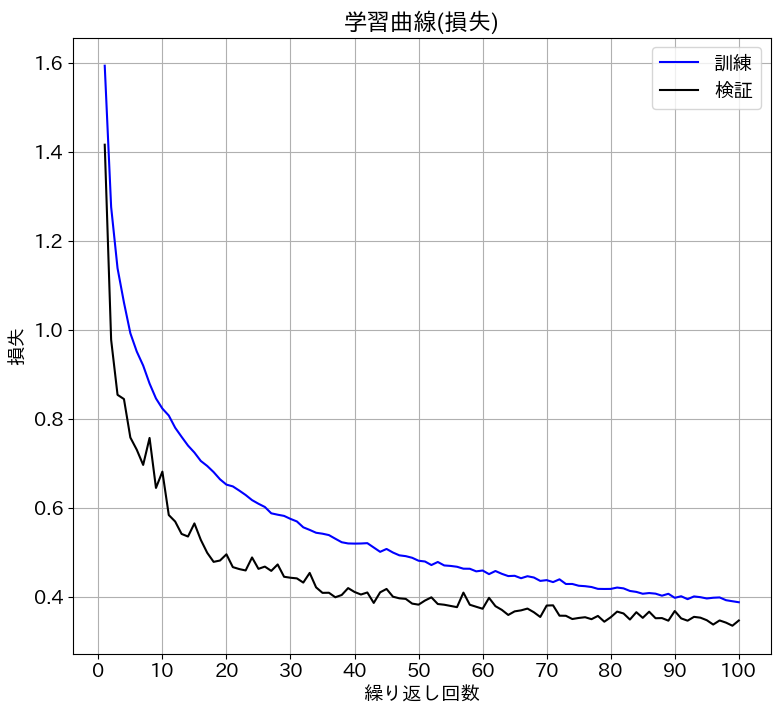

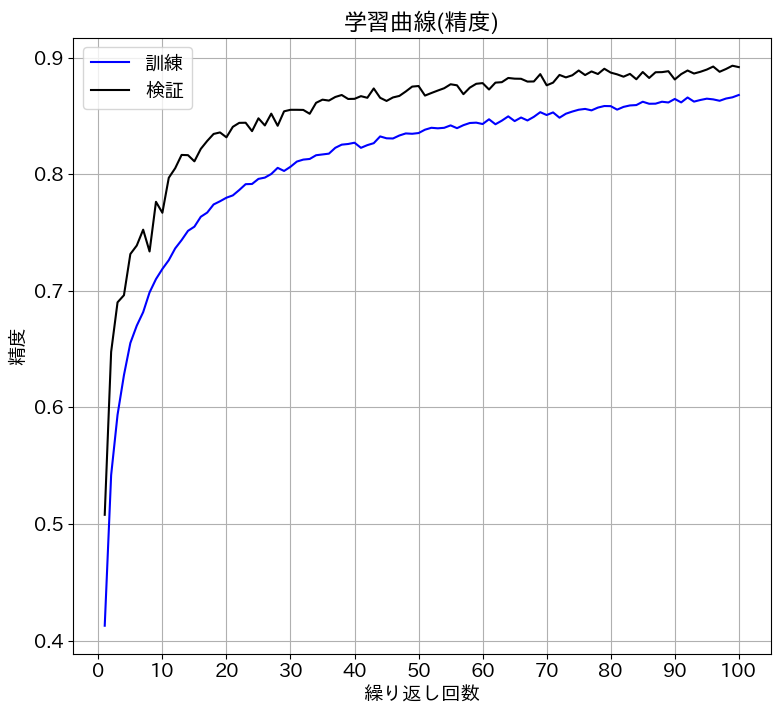

In [85]:
evaluate_history(history)

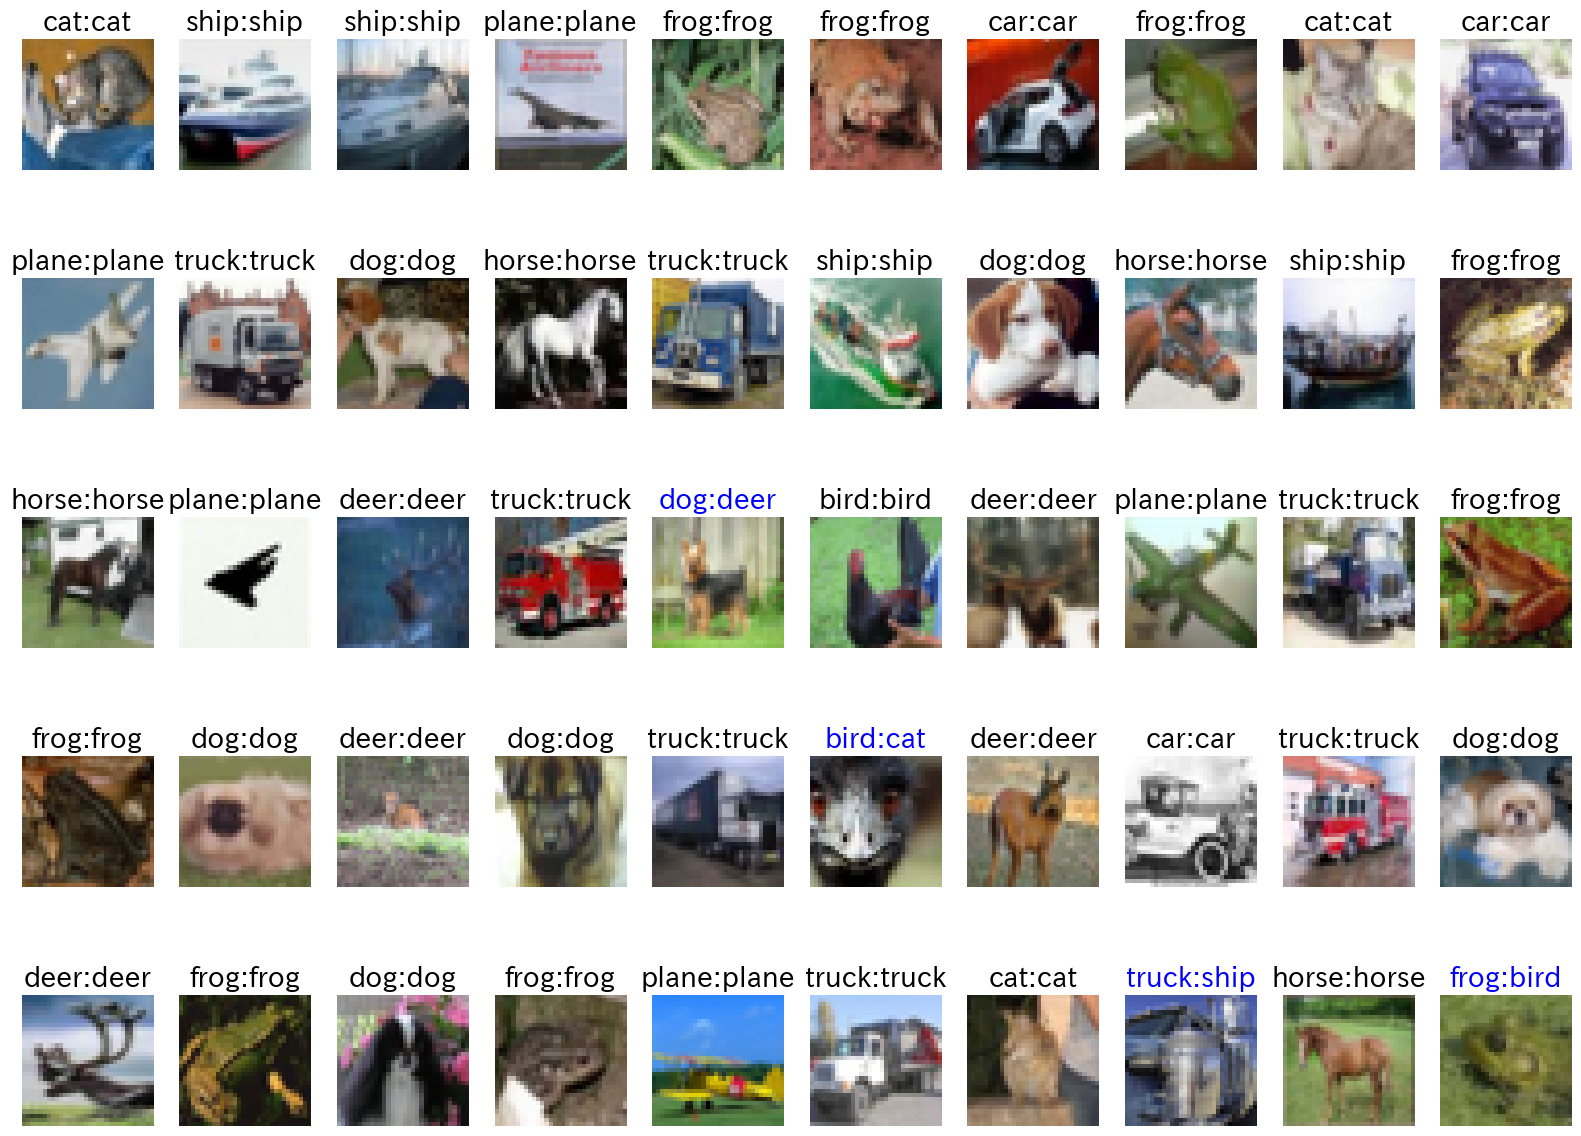

In [86]:
show_images_labels(test_loader, classes, net, device)

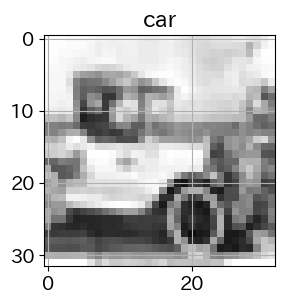

In [87]:
# 間違えた38番目のデータを抽出
for images, labels in test_loader:
    break
image = images[37]
label = labels[37]

# イメージを表示して確認
plt.figure(figsize=(3,3))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2 
plt.title(classes[label])
plt.imshow(w3)
plt.show()

In [88]:
# 予測値を取得
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

# ラベル別の確率値を表示
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
values = np.frompyfunc(lambda x: f'{x:.04f}', 1, 1)(probs_np)
names = np.array(classes)
tbl = np.array([names, values]).T
print(tbl)

[['plane' '0.0000']
 ['car' '0.7181']
 ['bird' '0.0000']
 ['cat' '0.0000']
 ['deer' '0.0000']
 ['dog' '0.0000']
 ['frog' '0.0000']
 ['horse' '0.0000']
 ['ship' '0.0000']
 ['truck' '0.2819']]


## コラム　Batch Normalization利用上の注意点

### ダメなクラス定義の例

In [89]:
class CNN_v5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn1,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn2,
            self.relu,
            self.conv4,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn3,
            self.relu,
            self.conv6,
            self.bn3,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [90]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [91]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

100%|██████████| 500/500 [00:14<00:00, 35.66it/s]


Epoch [1/50], loss: 1.50142 acc: 0.44870 val_loss: 1.87588, val_acc: 0.30450


100%|██████████| 500/500 [00:13<00:00, 36.08it/s]


Epoch [2/50], loss: 1.12936 acc: 0.59594 val_loss: 2.05476, val_acc: 0.23030


100%|██████████| 500/500 [00:14<00:00, 35.02it/s]


Epoch [3/50], loss: 0.98814 acc: 0.65392 val_loss: 1.91334, val_acc: 0.32260


100%|██████████| 500/500 [00:13<00:00, 36.98it/s]


Epoch [4/50], loss: 0.89346 acc: 0.69026 val_loss: 2.06456, val_acc: 0.26430


100%|██████████| 500/500 [00:13<00:00, 35.91it/s]


Epoch [5/50], loss: 0.82638 acc: 0.71612 val_loss: 2.29915, val_acc: 0.16220


100%|██████████| 500/500 [00:14<00:00, 35.66it/s]


Epoch [6/50], loss: 0.77164 acc: 0.73582 val_loss: 2.21090, val_acc: 0.20810


100%|██████████| 500/500 [00:13<00:00, 35.92it/s]


Epoch [7/50], loss: 0.72821 acc: 0.74998 val_loss: 2.11558, val_acc: 0.25360


100%|██████████| 500/500 [00:14<00:00, 35.39it/s]


Epoch [8/50], loss: 0.69044 acc: 0.76426 val_loss: 2.24539, val_acc: 0.19480


100%|██████████| 500/500 [00:15<00:00, 33.17it/s]


Epoch [9/50], loss: 0.65894 acc: 0.77504 val_loss: 2.52639, val_acc: 0.14040


100%|██████████| 500/500 [00:15<00:00, 33.24it/s]


Epoch [10/50], loss: 0.62493 acc: 0.78980 val_loss: 2.88648, val_acc: 0.16250


100%|██████████| 500/500 [00:14<00:00, 33.55it/s]


Epoch [11/50], loss: 0.60225 acc: 0.79844 val_loss: 2.52865, val_acc: 0.18380


100%|██████████| 500/500 [00:15<00:00, 33.18it/s]


Epoch [12/50], loss: 0.58129 acc: 0.80426 val_loss: 2.55655, val_acc: 0.15830


100%|██████████| 500/500 [00:13<00:00, 35.76it/s]


Epoch [13/50], loss: 0.55945 acc: 0.81160 val_loss: 2.41247, val_acc: 0.17570


100%|██████████| 500/500 [00:14<00:00, 34.98it/s]


Epoch [14/50], loss: 0.54074 acc: 0.81878 val_loss: 2.23365, val_acc: 0.17520


100%|██████████| 500/500 [00:14<00:00, 34.96it/s]


Epoch [15/50], loss: 0.52266 acc: 0.82350 val_loss: 2.32135, val_acc: 0.13690


100%|██████████| 500/500 [00:13<00:00, 35.97it/s]


Epoch [16/50], loss: 0.50534 acc: 0.83102 val_loss: 2.49186, val_acc: 0.10980


100%|██████████| 500/500 [00:14<00:00, 35.37it/s]


Epoch [17/50], loss: 0.48606 acc: 0.83742 val_loss: 2.73085, val_acc: 0.14050


100%|██████████| 500/500 [00:14<00:00, 35.31it/s]


Epoch [18/50], loss: 0.47615 acc: 0.84082 val_loss: 2.47903, val_acc: 0.15970


100%|██████████| 500/500 [00:13<00:00, 35.93it/s]


Epoch [19/50], loss: 0.46801 acc: 0.84454 val_loss: 2.40317, val_acc: 0.15330


100%|██████████| 500/500 [00:13<00:00, 36.71it/s]


Epoch [20/50], loss: 0.45188 acc: 0.84842 val_loss: 2.44270, val_acc: 0.16470


100%|██████████| 500/500 [00:14<00:00, 33.84it/s]


Epoch [21/50], loss: 0.43688 acc: 0.85274 val_loss: 2.40506, val_acc: 0.14210


100%|██████████| 500/500 [00:14<00:00, 35.68it/s]


Epoch [22/50], loss: 0.43002 acc: 0.85402 val_loss: 2.40982, val_acc: 0.12570


100%|██████████| 500/500 [00:14<00:00, 35.07it/s]


Epoch [23/50], loss: 0.41893 acc: 0.85928 val_loss: 2.45797, val_acc: 0.13340


100%|██████████| 500/500 [00:13<00:00, 36.67it/s]


Epoch [24/50], loss: 0.40735 acc: 0.86288 val_loss: 2.27417, val_acc: 0.18360


100%|██████████| 500/500 [00:13<00:00, 36.31it/s]


Epoch [25/50], loss: 0.39767 acc: 0.86728 val_loss: 2.47785, val_acc: 0.11760


100%|██████████| 500/500 [00:14<00:00, 35.04it/s]


Epoch [26/50], loss: 0.38791 acc: 0.86874 val_loss: 2.55510, val_acc: 0.12470


100%|██████████| 500/500 [00:13<00:00, 36.18it/s]


Epoch [27/50], loss: 0.38099 acc: 0.87050 val_loss: 2.53767, val_acc: 0.15470


100%|██████████| 500/500 [00:13<00:00, 36.33it/s]


Epoch [28/50], loss: 0.37368 acc: 0.87428 val_loss: 2.52167, val_acc: 0.13530


100%|██████████| 500/500 [00:14<00:00, 35.14it/s]


Epoch [29/50], loss: 0.36673 acc: 0.87694 val_loss: 2.57246, val_acc: 0.12700


100%|██████████| 500/500 [00:14<00:00, 35.34it/s]


Epoch [30/50], loss: 0.35541 acc: 0.88078 val_loss: 2.56218, val_acc: 0.12420


100%|██████████| 500/500 [00:14<00:00, 34.60it/s]


Epoch [31/50], loss: 0.35390 acc: 0.88170 val_loss: 2.62681, val_acc: 0.16370


100%|██████████| 500/500 [00:13<00:00, 36.51it/s]


Epoch [32/50], loss: 0.34689 acc: 0.88242 val_loss: 2.67619, val_acc: 0.13930


100%|██████████| 500/500 [00:13<00:00, 35.96it/s]


Epoch [33/50], loss: 0.33992 acc: 0.88520 val_loss: 2.53025, val_acc: 0.13500


100%|██████████| 500/500 [00:14<00:00, 33.83it/s]


Epoch [34/50], loss: 0.33664 acc: 0.88674 val_loss: 2.81526, val_acc: 0.10670


100%|██████████| 500/500 [00:13<00:00, 35.99it/s]


Epoch [35/50], loss: 0.32415 acc: 0.88928 val_loss: 2.57316, val_acc: 0.11030


100%|██████████| 500/500 [00:14<00:00, 35.16it/s]


Epoch [36/50], loss: 0.32014 acc: 0.89138 val_loss: 2.62475, val_acc: 0.13260


100%|██████████| 500/500 [00:14<00:00, 35.25it/s]


Epoch [37/50], loss: 0.31913 acc: 0.89124 val_loss: 2.70783, val_acc: 0.11410


100%|██████████| 500/500 [00:14<00:00, 35.35it/s]


Epoch [38/50], loss: 0.31173 acc: 0.89388 val_loss: 2.51562, val_acc: 0.13480


100%|██████████| 500/500 [00:14<00:00, 34.40it/s]


Epoch [39/50], loss: 0.30470 acc: 0.89604 val_loss: 2.52695, val_acc: 0.12890


100%|██████████| 500/500 [00:13<00:00, 36.02it/s]


Epoch [40/50], loss: 0.30636 acc: 0.89758 val_loss: 2.53115, val_acc: 0.13030


100%|██████████| 500/500 [00:13<00:00, 36.08it/s]


Epoch [41/50], loss: 0.30140 acc: 0.89686 val_loss: 2.63281, val_acc: 0.10280


100%|██████████| 500/500 [00:13<00:00, 35.84it/s]


Epoch [42/50], loss: 0.29899 acc: 0.89712 val_loss: 2.66028, val_acc: 0.11060


100%|██████████| 500/500 [00:14<00:00, 33.80it/s]


Epoch [43/50], loss: 0.29561 acc: 0.89894 val_loss: 2.59843, val_acc: 0.11330


100%|██████████| 500/500 [00:14<00:00, 33.59it/s]


Epoch [44/50], loss: 0.29086 acc: 0.90088 val_loss: 2.73196, val_acc: 0.10380


100%|██████████| 500/500 [00:14<00:00, 35.21it/s]


Epoch [45/50], loss: 0.29003 acc: 0.90204 val_loss: 2.65204, val_acc: 0.10870


100%|██████████| 500/500 [00:14<00:00, 35.60it/s]


Epoch [46/50], loss: 0.28296 acc: 0.90366 val_loss: 2.79138, val_acc: 0.10230


100%|██████████| 500/500 [00:13<00:00, 36.10it/s]


Epoch [47/50], loss: 0.27629 acc: 0.90584 val_loss: 2.75571, val_acc: 0.10030


100%|██████████| 500/500 [00:14<00:00, 34.74it/s]


Epoch [48/50], loss: 0.27794 acc: 0.90606 val_loss: 2.72743, val_acc: 0.10640


100%|██████████| 500/500 [00:14<00:00, 35.71it/s]


Epoch [49/50], loss: 0.27183 acc: 0.90712 val_loss: 2.59349, val_acc: 0.13110


100%|██████████| 500/500 [00:14<00:00, 35.36it/s]


Epoch [50/50], loss: 0.26158 acc: 0.91042 val_loss: 2.75877, val_acc: 0.11680


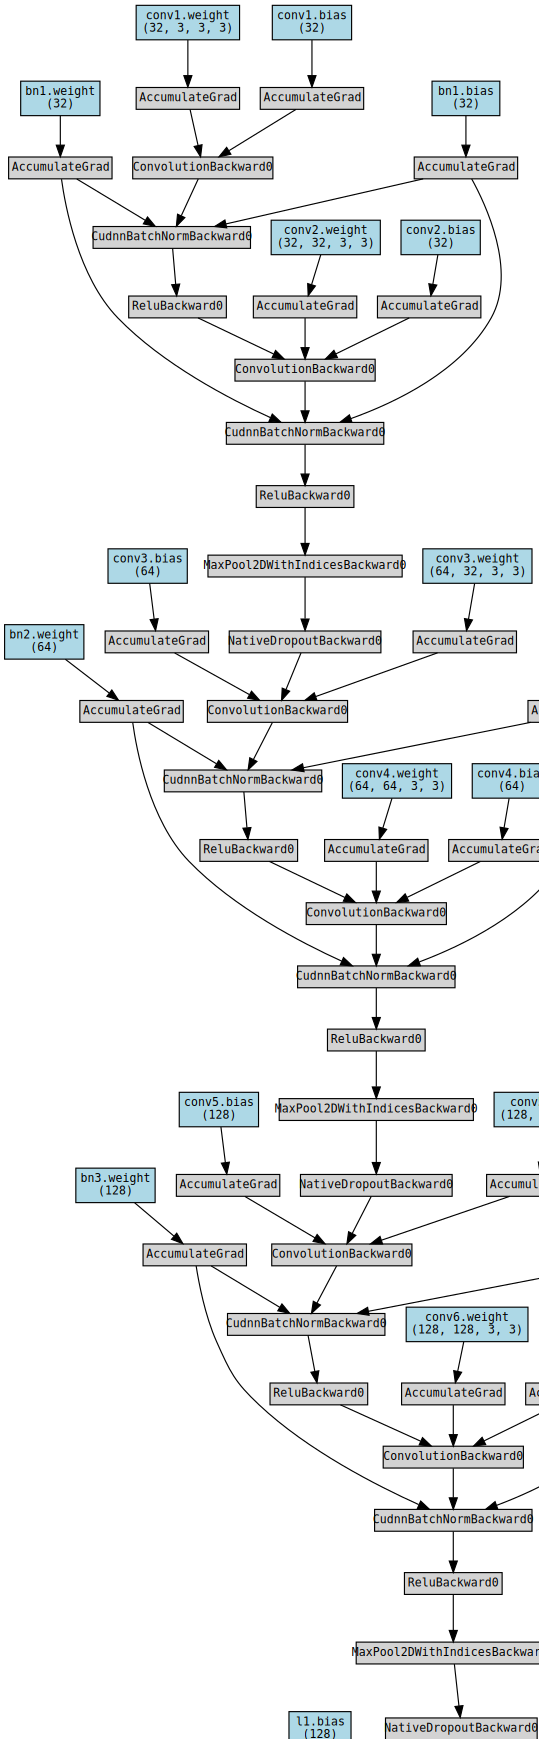

In [92]:
# 損失の計算グラフ可視化
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## コラム Batch Normlizationの処理内容

In [93]:
# 入力用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 1, 10)
print(inputs)

tensor([[[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724,
          -0.7550,  0.3239, -0.1085]]])


In [94]:
# 入力ミニバッチデータの統計量計算

i_mean = inputs.mean()
i_var = inputs.var(unbiased=True)
i_std = inputs.std(unbiased=False)
print(i_mean, i_std, i_var)

tensor(-0.3101) tensor(0.4867) tensor(0.2632)


In [95]:
# BN関数の定義

bn = nn.BatchNorm1d(1)
print(bn.running_mean)
print(bn.running_var)
print(bn.weight.data)
print(bn.bias.data)

tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])


In [96]:
# BN関数の疑似呼び出し

bn.train()
print('===訓練フェーズ1===')
outputs1 = bn(inputs)
print(outputs1.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測フェーズ1===')
outputs2 = bn(inputs)
print(outputs2.data)
print(bn.running_mean)
print(bn.running_var)

bn.train()
print('===訓練フェーズ2===')
outputs3 = bn(inputs)
print(outputs3.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測フェーズ2===')
outputs4 = bn(inputs)
print(outputs4.data)
print(bn.running_mean)
print(bn.running_var)


===訓練フェーズ1===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0310])
tensor([0.9263])
===予測フェーズ1===
tensor([[[-0.0836,  0.1573, -0.3518, -0.2176, -1.2114,  0.2496, -0.9781,
          -0.7523,  0.3688, -0.0805]]])
tensor([-0.0310])
tensor([0.9263])
===訓練フェーズ2===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0589])
tensor([0.8600])
===予測フェーズ2===
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([-0.0589])
tensor([0.8600])


In [97]:
# 訓練フェーズの出力

xt = (inputs - i_mean)/i_std * bn.weight + bn.bias
print(xt.data)

print(outputs1.data)

tensor([[[ 0.4081,  0.8845, -0.1224,  0.1431, -1.8223,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])


In [98]:
# 予測フェーズの出力

xp = (inputs-bn.running_mean)/torch.sqrt(bn.running_var)
print(xp.data)

print(outputs4.data)

tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])


In [99]:
# running_meanとrunnung_varの計算式

# 初期値
mean0 = 0
var0 = 1
momentum = bn.momentum

# 移動平均計算1回目
mean1 = (1-momentum) * mean0 +  momentum * i_mean
var1 = (1-momentum) * var0 +  momentum * i_var
print(mean1, var1)

# 移動平均計算2回目
mean2 = (1-momentum) * mean1 +  momentum * i_mean
var2 = (1-momentum) * var1 +  momentum * i_var
print(mean2, var2)


tensor(-0.0310) tensor(0.9263)
tensor(-0.0589) tensor(0.8600)
